# 1. Imports, File Extraction and Data Cleaning

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sn
sn.set()
import statistics
import datetime
import sys
from io import StringIO
import statsmodels.api as sm


In [2]:
listings_adam = pd.read_csv('data/adam/listings.csv')
listings_rdam = pd.read_csv('data/rdam/listings.csv')
listings_haag = pd.read_csv('data/haag/listings.csv')

reviews_adam = pd.read_csv('data/adam/reviews.csv')
reviews_rdam = pd.read_csv('data/rdam/reviews.csv')
reviews_haag = pd.read_csv('data/haag/reviews.csv')

In [3]:
# Function to clean the listings dataframes, by dropping certain columns and converting 
# others to useful types and creating some deducted columns

def clean_listings(df):
    df = df.drop(columns=['listing_url','scrape_id','last_scraped','picture_url','host_url',
                          'host_thumbnail_url','host_picture_url','neighbourhood_group_cleansed',
                          'calendar_updated','calendar_last_scraped','minimum_minimum_nights',
                          'maximum_minimum_nights','minimum_maximum_nights',
                          'maximum_maximum_nights','has_availability','bathrooms'])
    
    # String entries to Boolean
    df['host_is_superhost'] = df['host_is_superhost'].isin(['t'])
    df['host_identity_verified'] = df['host_identity_verified'].isin(['t'])
    df['instant_bookable'] = df['instant_bookable'].isin(['t'])
    df['host_has_profile_pic'] = df['host_has_profile_pic'].isin(['t'])
    
    df['host_since'] = pd.to_datetime(df['host_since'])
    df['first_review'] = pd.to_datetime(df['first_review'])
    df['last_review'] = pd.to_datetime(df['last_review'])
    
    # String percent entries to value between 0 and 1
    df['host_response_rate'] = pd.to_numeric(df['host_response_rate'].str.strip('%'))/100
    df['host_acceptance_rate'] = pd.to_numeric(df['host_acceptance_rate'].str.strip('%'))/100
    
    df['price'] = df['price'].str.strip('$').str.replace(',','').astype(float)
    
    # To make list entries
    df['host_verifications'] = df['host_verifications'].str.strip('[').str.strip(']').str.replace('\'','').str.replace(' ','').str.split(',')
    df['amenities'] = df['amenities'].str.strip('[').str.strip(']').str.replace('"','').str.replace(', ',',').str.split(',')
    
    # New possibly interesting columns
    df['no_host_verifications'] = df['host_verifications'].apply(len)
    df['no_amenities'] = df['amenities'].apply(len)
    df['days_host'] = (datetime.date.today() - df['host_since'].dt.date).dt.days
    df['since_last_review'] = (datetime.date.today() - df['last_review'].dt.date).dt.days
    df['min_cost'] = df['price']*df['minimum_nights']
    df["length_description"] = df["description"].apply(str).apply(len)
    df["neigh_description"] = df["neighborhood_overview"].apply(str).apply(len)
     
    # For combined dataframes city filter
    df['city'] = df['neighbourhood'].iloc[0].split(',')[0]
    
    return df

In [4]:
clean_adam = clean_listings(listings_adam.copy())
clean_rdam = clean_listings(listings_rdam.copy())
clean_haag = clean_listings(listings_haag.copy())
clean_all = pd.concat([clean_adam,clean_rdam,clean_haag], ignore_index=True)

# 2. Data Insights

## 2.1 Listings

In [5]:
# Function to get a summary of insights on the listings data of a given listings dataframe

def summary(df):
    no_listings = len(df.index)
    
    mean_rating = round(np.mean(df['review_scores_rating']),2)
    avg_amenities = round(np.mean(df['no_amenities']),2)
    mean_price = round(np.mean(df['price']),2)
    avg_min_cost = round(np.mean(df['min_cost']))
    total_reviews = sum(df['number_of_reviews'])
    
    print('Average rating:',mean_rating)
    print('Total amount of listings:', no_listings)
    print('Average listing price:',mean_price,'dollars')
    print('Average number of amenities:',avg_amenities)
    print('Total number of reviews:',total_reviews)
    print()
    
    # Frequencies of categorical values
    neighbourhoods = df['neighbourhood_cleansed'].value_counts()
    print(neighbourhoods,'\n')
    room_types = df['room_type'].value_counts()
    print(room_types,'\n')
    accommodates = df['accommodates'].value_counts()
    print(accommodates,'\n')
    bedrooms = df['bedrooms'].value_counts()
    print(bedrooms,'\n')
    beds = df['beds'].value_counts()
    print(beds,'\n')
    
    avg_no_reviews = round(np.mean(df['number_of_reviews']),1)
    ltm_reviews = sum(df['number_of_reviews_ltm'])
    avg_ltm_reviews = round(np.mean(df['number_of_reviews_ltm']),1)
    l30d_reviews = sum(df['number_of_reviews_l30d'])
    avg_l30d_reviews = round(np.mean(df['number_of_reviews_l30d']),1)
    days_since_first = (datetime.date.today() - df['first_review'].dt.date).dt.days
    mean_days_since_first = round(np.mean(days_since_first))
    days_since_last = (datetime.date.today() - df['last_review'].dt.date).dt.days
    mean_days_since_last = round(np.mean(days_since_last))
    
#     plt.hist(days_since_first)
#     plt.show()
#     plt.hist(days_since_last)
#     plt.show()

    plt.scatter(df["neigh_description"],df["review_scores_accuracy"])
    plt.show()

    # Function creating a horizontal barplot of the top 5 for a given series,
    # using string arguments for "col" and "by" to create the title and x-axis label.
    def top5_barh_plot(series, col, by):
        series.head().plot.barh(figsize=(8,10),color = 'r', width=0.8)
        plt.title(col + " By " + by)
        plt.xlabel(col)
        plt.gca().invert_yaxis()
        plt.ylabel('')
        plt.show()
 
    rating_by_loc = df['review_scores_location'].groupby(df['neighbourhood_cleansed']).mean().sort_values(ascending=False)
#     print(round(rating_by_loc,2))
#     top5_barh_plot(rating_by_loc,"Average Rating","Neighbourhood")

    listings_by_loc = neighbourhoods
#     print(listings_by_loc)
#     top5_barh_plot(listings_by_loc,'Number of Listings','Neighbourhood')
    
    price_by_loc = df['price'].groupby(df['neighbourhood_cleansed']).mean().sort_values(ascending=False)
#     print(round(price_by_loc,2),'\n')
#     top5_barh_plot(price_by_loc,"Average Price",'Neighbourhood')

    reviews_by_loc = df['number_of_reviews'].groupby(df['neighbourhood_cleansed']).sum().sort_values(ascending=False)
#     print(reviews_by_loc,'\n')
#     top5_barh_plot(reviews_by_loc,"Number Of Reviews",'Neighbourhood')
    
    rating_by_type = df['review_scores_rating'].groupby(df['room_type']).mean().sort_values(ascending=False)
#     print(rating_by_type,'\n')
#     top5_barh_plot(rating_by_type,"Average Rating",'Room Type')

    value_by_type = df['review_scores_value'].groupby(df['room_type']).mean().sort_values(ascending=False)
#     print(value_by_type,'\n')
#     top5_barh_plot(value_by_type,"Average Value Rating",'Room Type')
    
    price_by_type = df['price'].groupby(df['room_type']).mean().sort_values(ascending=False)
#     print(price_by_type,'\n')
#     top5_barh_plot(price_by_type,"Average Price",'Room Type')

    listings_by_type = room_types
#     print(listings_by_type,'\n')
#     top5_barh_plot(listings_by_type,"Number of Listings",'Room Type')

    rating_by_prop = df['review_scores_rating'].groupby(df['property_type']).mean().sort_values(ascending=False)
#     print(rating_by_prop,'\n')
#     top5_barh_plot(rating_by_prop,"Average Rating",'Property Type')
    
    listings_by_acc = accommodates
#     print(listings_by_acc,'\n')
#     top5_barh_plot(listings_by_acc,"Number of Listings",'Number of Accommodates')

    value_by_acc = df['review_scores_value'].groupby(df['accommodates']).mean().sort_values(ascending=True)
#     print(value_by_acc,'\n')
#     top5_barh_plot(value_by_acc,"Average Value Rating",'Number of Accommodates')
    
    price_by_acc = df['price'].groupby(df['accommodates']).mean().sort_values(ascending=True)
#     print(price_by_acc,'\n')
#     top5_barh_plot(price_by_acc,"Average Price",'Number of Accommodates')
    
    price_by_guest = price_by_acc.div(price_by_acc.keys()).sort_values(ascending=True)
#     print(price_by_guest,'\n')
#     top5_barh_plot(price_by_guest,"Average Price Per Accomodate",'Number Of Accommodates')
    
    # Function that creates a correlation matrix for a given DF and string "group" for the title
    # and list of strings "lables" for the tick labels
    def corr_matrix(df, group, labels):
        sn.heatmap(df.corr(),cmap='seismic', annot=True,xticklabels=False, yticklabels=labels)
        plt.title("Correlation Matrix grouped by "+ group)
        plt.show()
       
    labels = ['Average Location Rating','Number of Listings','Average Price','Total Reviews']
    nbh = pd.concat([round(rating_by_loc,2),listings_by_loc,
                     round(price_by_loc,2),reviews_by_loc],axis=1,join='inner',keys=labels)
    nbh = nbh[nbh["Total Reviews"] > 50]
    corr_matrix(nbh,"Neighbourhood",labels)
    
    plt.scatter(nbh['Average Location Rating'],nbh['Average Price'])
    plt.show()
    
    plt.scatter(nbh['Total Reviews']/nbh["Number of Listings"],nbh['Average Price'])
    plt.show()

    labels = ['Average Price', 'Average Rating', 'Average Value Rating', 'Number of Listings']
    types =pd.concat([round(price_by_type,2),round(rating_by_type,2),round(value_by_type,2),listings_by_type],
                      axis=1,join='inner', keys=labels)
    corr_matrix(types,"Room Types",labels)
    
    labels = ['Average Total Price', 'Average Price Per Accommodate', 'Average Value Rating',
              'Number of Listings']
    acc = pd.concat([round(price_by_acc,2),round(price_by_guest,2),round(value_by_acc,2),
                     listings_by_acc],axis=1,join='inner',keys=labels)
    corr_matrix(acc,"Number of Accomodates",labels)

Average rating: 4.79
Total amount of listings: 5732
Average listing price: 174.61 dollars
Average number of amenities: 27.5
Total number of reviews: 284140

Centrum-West                              861
De Baarsjes - Oud-West                    836
Centrum-Oost                              609
De Pijp - Rivierenbuurt                   563
Westerpark                                379
Zuid                                      371
Oud-Oost                                  310
Bos en Lommer                             249
Oud-Noord                                 247
Oostelijk Havengebied - Indische Buurt    207
Watergraafsmeer                           196
IJburg - Zeeburgereiland                  168
Noord-West                                136
Noord-Oost                                125
Geuzenveld - Slotermeer                    98
Slotervaart                                94
Buitenveldert - Zuidas                     73
De Aker - Nieuw Sloten                     64
Gaasperdam - Dr

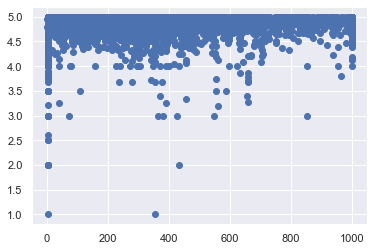

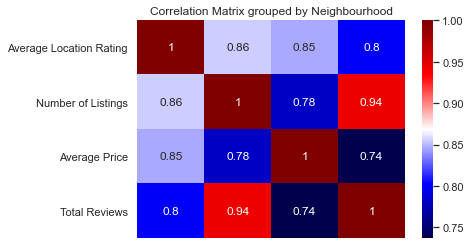

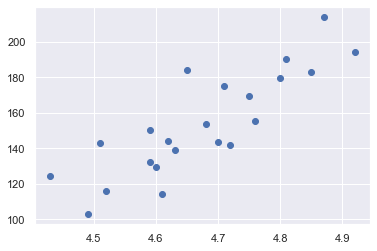

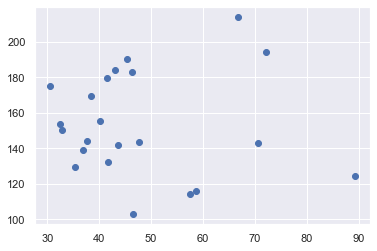

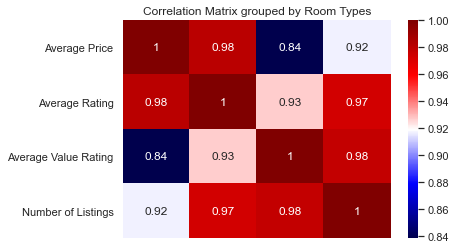

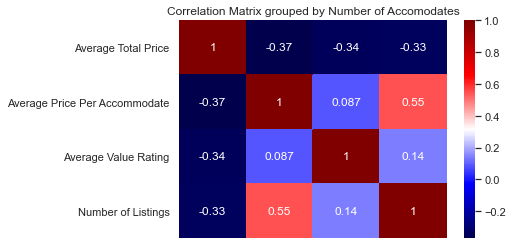

In [6]:
summary(clean_adam)

Average rating: 4.73
Total amount of listings: 753
Average listing price: 132.31 dollars
Average number of amenities: 30.14
Total number of reviews: 30336

Scheveningen Badplaats    71
Vissershaven              38
Huygenspark               36
Belgisch Park             34
Kortenbos                 32
                          ..
De Bras                    1
Moerwijk-Noord             1
Hoge Veld                  1
Componistenbuurt           1
Bosjes van Pex             1
Name: neighbourhood_cleansed, Length: 85, dtype: int64 

Entire home/apt    522
Private room       217
Hotel room          11
Shared room          3
Name: room_type, dtype: int64 

2     321
4     181
5      62
3      60
6      55
1      41
8      13
7      11
9       4
10      2
0       1
14      1
16      1
Name: accommodates, dtype: int64 

1.0    373
2.0    171
3.0     80
4.0     39
5.0      6
6.0      4
Name: bedrooms, dtype: int64 

1.0     327
2.0     175
4.0      88
3.0      76
5.0      40
6.0      21
7.0       

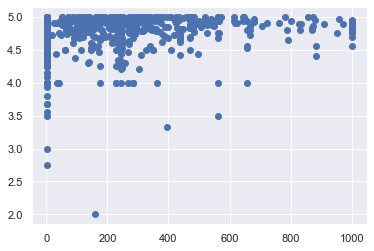

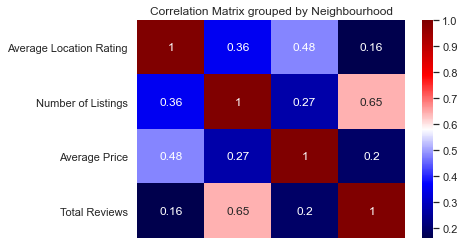

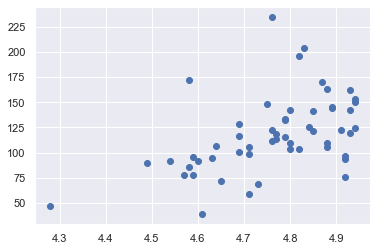

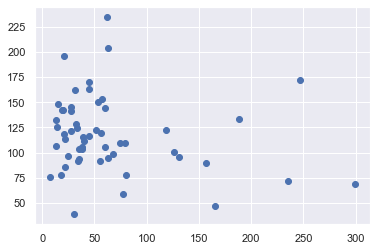

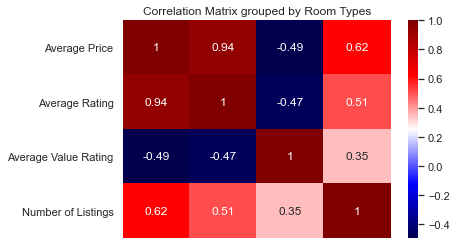

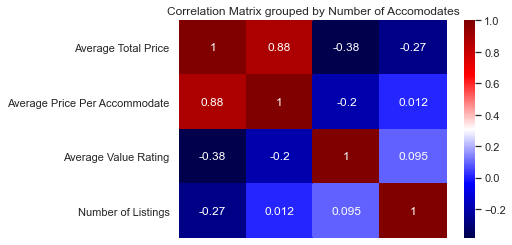

In [7]:
summary(clean_haag)

Average rating: 4.71
Total amount of listings: 679
Average listing price: 128.28 dollars
Average number of amenities: 29.75
Total number of reviews: 28504

Stadsdriehoek      59
Middelland         49
Nieuwe Westen      49
Cool               47
Cs Kwartier        33
                   ..
Zestienhoven        1
Pernis              1
Nieuw Crooswijk     1
Eemhaven            1
Dorp                1
Name: neighbourhood_cleansed, Length: 75, dtype: int64 

Entire home/apt    438
Private room       215
Hotel room          14
Shared room         12
Name: room_type, dtype: int64 

2     344
4     145
3      55
6      45
1      42
8      18
5      14
16      7
9       2
10      2
12      2
0       1
7       1
13      1
Name: accommodates, dtype: int64 

1.0     425
2.0     152
3.0      39
4.0      11
10.0      4
5.0       3
6.0       3
8.0       2
7.0       2
9.0       1
23.0      1
Name: bedrooms, dtype: int64 

1.0     340
2.0     173
3.0      57
4.0      38
5.0      16
6.0      15
8.0      11

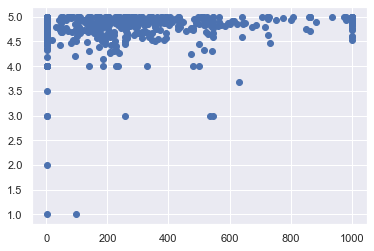

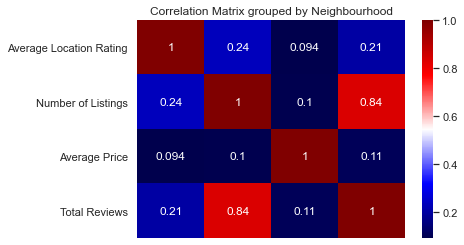

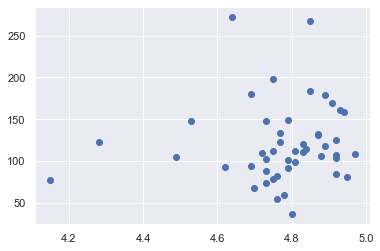

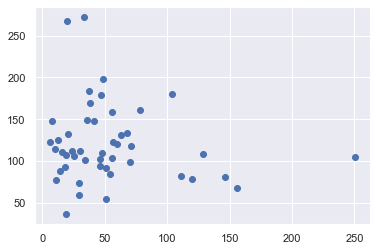

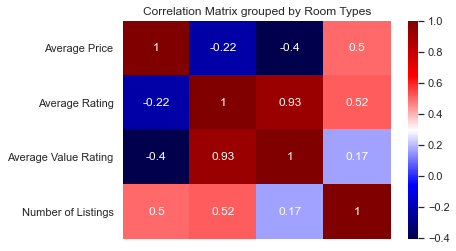

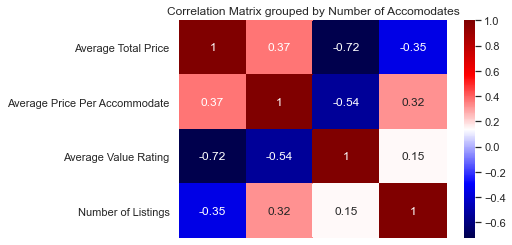

In [8]:
summary(clean_rdam)

Average rating: 4.78
Total amount of listings: 7164
Average listing price: 165.78 dollars
Average number of amenities: 27.99
Total number of reviews: 342980

Centrum-West               861
De Baarsjes - Oud-West     836
Centrum-Oost               609
De Pijp - Rivierenbuurt    563
Westerpark                 379
                          ... 
Westbroekpark                1
Beverwaard                   1
De Bras                      1
Waldeck-Zuid                 1
De Rivieren                  1
Name: neighbourhood_cleansed, Length: 182, dtype: int64 

Entire home/apt    4788
Private room       2224
Hotel room          113
Shared room          39
Name: room_type, dtype: int64 

2     3661
4     2132
3      548
6      253
1      238
5      182
8       48
7       33
16      25
12      12
9        9
0        8
10       6
13       4
14       4
15       1
Name: accommodates, dtype: int64 

1.0     4168
2.0     1625
3.0      631
4.0      225
5.0       40
6.0       11
10.0       9
8.0        5


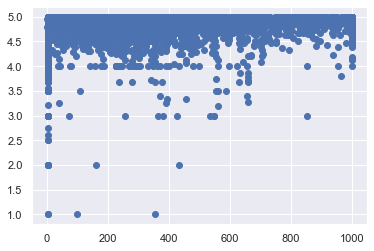

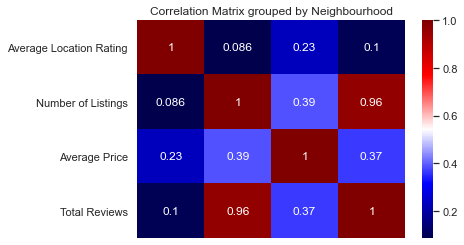

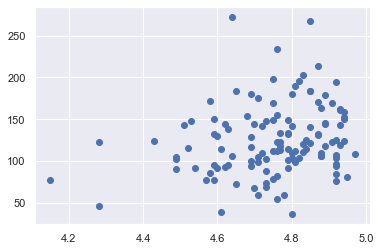

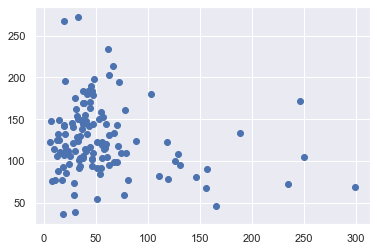

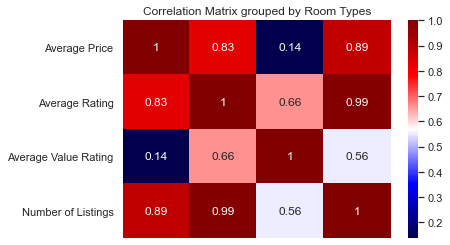

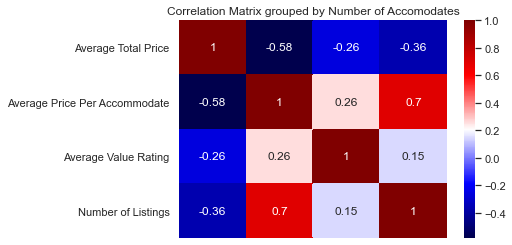

In [9]:
summary(clean_all)

## 2.2 Hosts

In [10]:
# Function to get a summary of insights on the host in listings dataframe

def hosts(df):
    # Filtering for host columns, dropping verifications to be able to drop duplicates
    hosts = df.loc[:,'host_id':'host_identity_verified'].drop(['host_verifications'],axis=1).drop_duplicates()
    hosts = hosts.merge(df[['days_host','no_host_verifications']], left_index=True,right_index=True)
    
    no_hosts = len(hosts.index)
    active_hosts = len(hosts[hosts['host_total_listings_count']>0].index)
    mean_days_host = round(np.mean(hosts['days_host']))
    mean_resp = round(np.mean(hosts['host_response_rate']),4)
    mean_acc = round(np.mean(hosts['host_acceptance_rate']),4)
    avg_verifications = round(np.mean(hosts['no_host_verifications']),2)
    superhosts = hosts['host_is_superhost'].value_counts()[True]
    verified_hosts = hosts['host_identity_verified'].value_counts()[True]
    have_no_pic = hosts['host_has_profile_pic'].value_counts()[False]
    
    print('Total amount of hosts:', no_hosts,'of which',active_hosts, 'are still active.')
    print('Average days of being a host:',mean_days_host)
    print('Average response rate:', str(mean_resp*100)+"%", 'and acceptance rate:',str(mean_acc*100)+"%")
    print('There are', superhosts,'superhosts.')
    print('There are', verified_hosts,'hosts that have verified their identity and',
          have_no_pic,'hosts without a profile picture.')
    print('Average verifications:',avg_verifications)

In [11]:
hosts(clean_adam)

Total amount of hosts: 4607 of which 3668 are still active.
Average days of being a host: 2591
Average response rate: 93.96% and acceptance rate: 74.5%
There are 1118 superhosts.
There are 3655 hosts that have verified their identity and 15 hosts without a profile picture.
Average verifications: 5.16


In [12]:
hosts(clean_haag)

Total amount of hosts: 440 of which 316 are still active.
Average days of being a host: 2356
Average response rate: 94.12% and acceptance rate: 80.71000000000001%
There are 157 superhosts.
There are 354 hosts that have verified their identity and 2 hosts without a profile picture.
Average verifications: 4.88


In [13]:
hosts(clean_rdam)

Total amount of hosts: 474 of which 298 are still active.
Average days of being a host: 2320
Average response rate: 94.55% and acceptance rate: 78.34%
There are 136 superhosts.
There are 372 hosts that have verified their identity and 2 hosts without a profile picture.
Average verifications: 4.9


In [14]:
hosts(clean_all)

Total amount of hosts: 5518 of which 4279 are still active.
Average days of being a host: 2549
Average response rate: 94.04% and acceptance rate: 75.41%
There are 1410 superhosts.
There are 4379 hosts that have verified their identity and 19 hosts without a profile picture.
Average verifications: 5.11


## 2.3 Reviews

In [15]:
# Function that plots frequency of reviews over the months of a year.
def review(city):
    
    month = pd.to_datetime(city['date'], format = '%Y-%m-%d').dt.month
    
    groupMonth = month.groupby(month).size()
    
    plt.plot(groupMonth.index, groupMonth.values)
    plt.show()
    
    return groupMonth

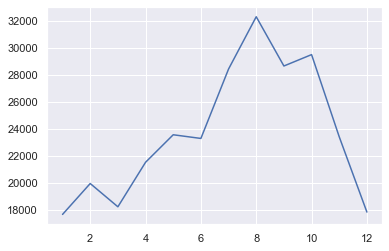

date
1     17647
2     19935
3     18212
4     21507
5     23545
6     23272
7     28412
8     32283
9     28636
10    29479
11    23392
12    17820
Name: date, dtype: int64

In [16]:
review(reviews_adam)

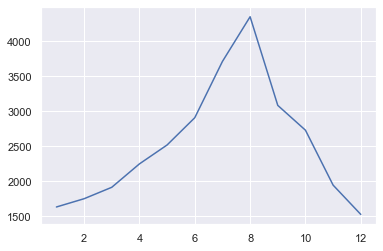

date
1     1635
2     1753
3     1916
4     2250
5     2520
6     2909
7     3712
8     4350
9     3085
10    2731
11    1947
12    1529
Name: date, dtype: int64

In [17]:
review(reviews_haag)

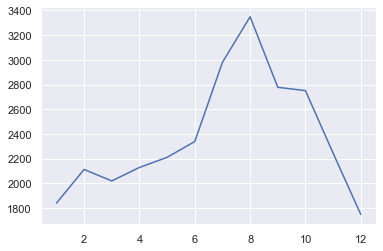

date
1     1840
2     2113
3     2020
4     2129
5     2211
6     2339
7     2980
8     3349
9     2778
10    2751
11    2245
12    1749
Name: date, dtype: int64

In [18]:
review(reviews_rdam)

## 2.4 Plots

<AxesSubplot:title={'center':'price'}, xlabel='[city]'>

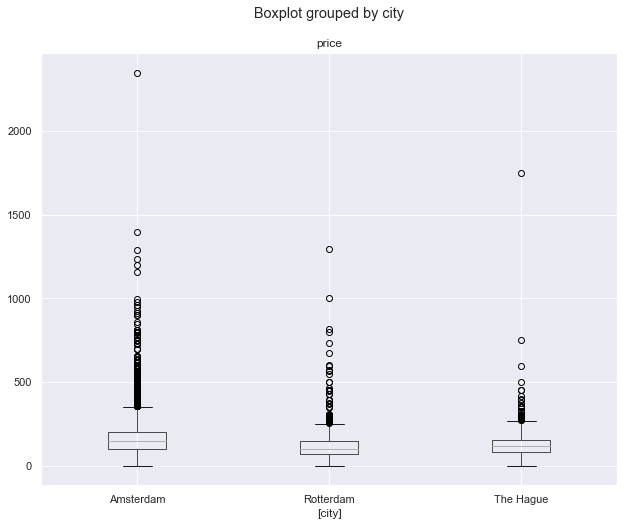

In [19]:
clean_all[['city','price']][clean_all['price']<6000].boxplot(by = 'city', figsize=(10, 8))

In [20]:
def amenities_plots(df):
    for city in df['city'].value_counts().keys():
        df2 = df[df['city']==city]
        plt.scatter(df2['no_amenities'][df2['price']<5000], df2['price'][df2['price']<5000])
        plt.title(city+": Number of Amenities vs Price (under $5,000)")
        plt.xlabel("Number of Amenities")
        plt.ylabel("Price (under $5,000)")
        plt.show()

        plt.scatter(df2['no_amenities'], df2['review_scores_rating'])
        plt.title(city+": Number of Amenities vs Rating")
        plt.xlabel("Number of Amenities")
        plt.ylabel("Rating")
        plt.show()

        plt.scatter(df2['no_amenities'], df2['review_scores_value'])
        plt.title(city+": Number of Amenities vs Value Rating")
        plt.xlabel("Number of Amenities")
        plt.ylabel("Value Rating")
        plt.show()
        
    plt.scatter(df['no_amenities'][df['price']<5000], df['price'][df['price']<5000])
    plt.title("All: Number of Amenities vs Price (under $5,000)")
    plt.xlabel("Number of Amenities")
    plt.ylabel("Price (under $5,000)")
    plt.show()

    plt.scatter(df['no_amenities'], df['review_scores_rating'])
    plt.title("All: Number of Amenities vs Rating")
    plt.xlabel("Number of Amenities")
    plt.ylabel("Rating")
    plt.show()

    plt.scatter(df['no_amenities'], df['review_scores_value'])
    plt.title("All: Number of Amenities vs Value Rating")
    plt.xlabel("Number of Amenities")
    plt.ylabel("Value Rating")
    plt.show()

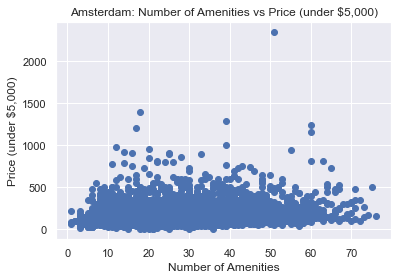

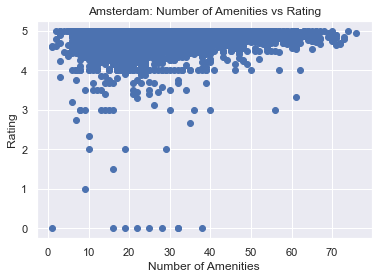

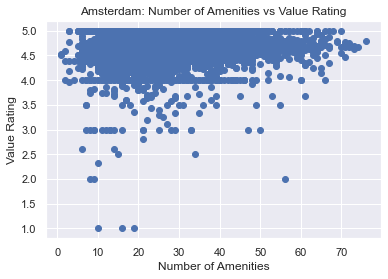

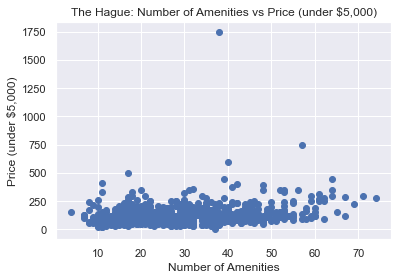

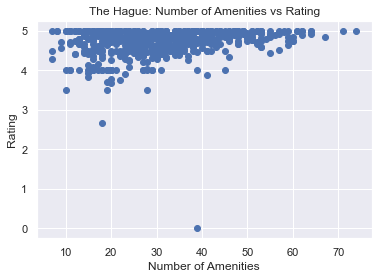

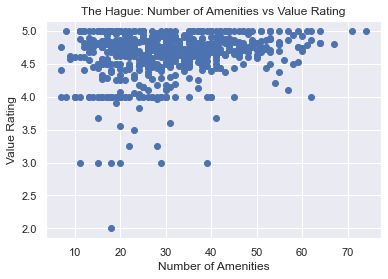

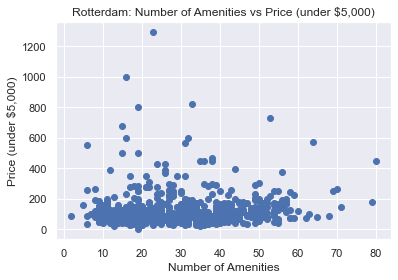

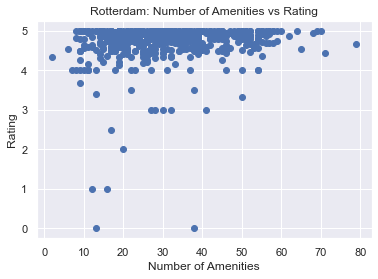

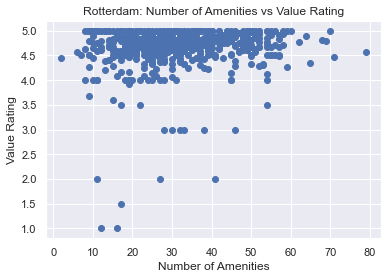

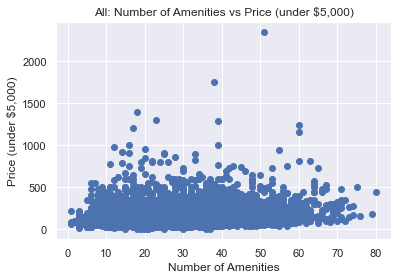

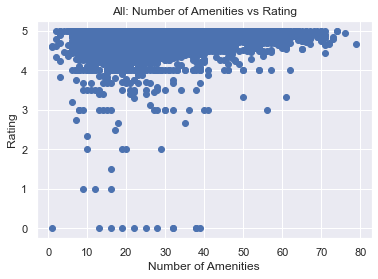

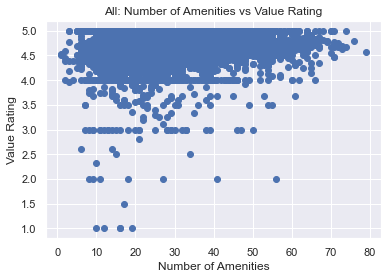

In [21]:
amenities_plots(clean_all)

In [22]:
def city_graph(col):
    df = clean_all.copy()
    filt = df[col].value_counts().sort_values(ascending=True)
    filt.plot.barh(figsize=(12,3),width=0.9,color=['g','y','r'])
    plt.title("Number of Listings by " + col)
    plt.xlabel("Number of Listings")
    plt.show()

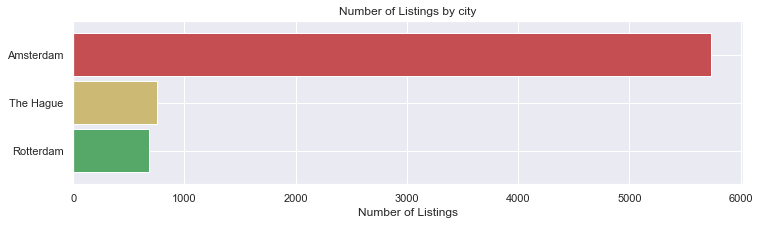

In [23]:
city_graph('city')

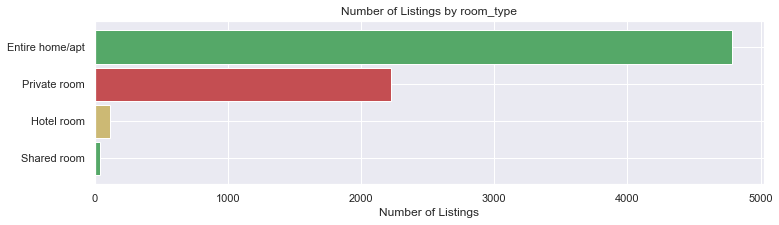

In [24]:
city_graph('room_type')

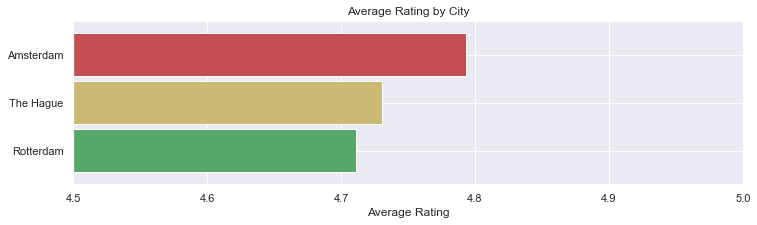

In [25]:
df = clean_all.copy()
filtered = df['review_scores_rating'].groupby(df['city']).mean().sort_values(ascending=True)
filtered.plot.barh(figsize=(12,3),width=0.9,color=['g','y','r'])
plt.title("Average Rating by City")
plt.xlabel("Average Rating")
plt.xlim(4.5,5)
plt.ylabel("")
plt.show()

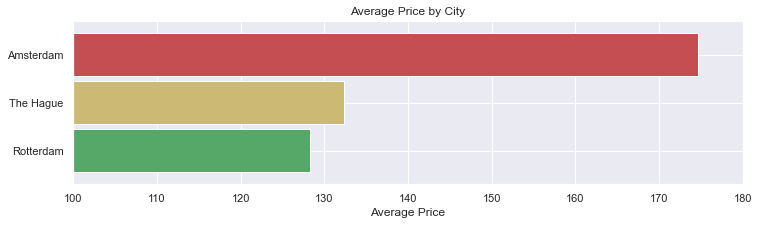

In [26]:
df = clean_all.copy()
filtered = df['price'].groupby(df['city']).mean().sort_values(ascending=True)
filtered.plot.barh(figsize=(12,3),width=0.9,color=['g','y','r'])
plt.title("Average Price by City")
plt.xlabel("Average Price")
plt.xlim(100,180)
plt.ylabel("")
plt.show()

In [27]:
corr = clean_all[['host_response_rate','host_acceptance_rate','accommodates','bedrooms','beds','price',
                  'min_cost','days_host','number_of_reviews','review_scores_rating',
                 'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
                 'review_scores_communication','review_scores_location','review_scores_value',
                'reviews_per_month']].corr()
corr

,host_response_rate,host_acceptance_rate,accommodates,bedrooms,beds,price,min_cost,days_host,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
host_response_rate,1.000000,0.314447,-0.019807,-0.047730,-0.019760,-0.063845,-0.059418,0.024677,0.117911,0.083183,0.062781,0.074259,0.060902,0.073797,0.029452,0.036993,0.094584
host_acceptance_rate,0.314447,1.000000,-0.058614,-0.137141,-0.046088,-0.058936,-0.078501,-0.224796,0.194488,-0.051716,-0.094578,-0.026561,-0.066296,-0.089863,-0.009684,-0.059417,0.229214
accommodates,-0.019807,-0.058614,1.000000,0.737168,0.804810,0.287130,0.033909,0.035061,-0.083541,-0.038861,-0.070942,-0.092662,-0.043472,-0.035417,-0.080353,-0.072977,-0.080845
bedrooms,-0.047730,-0.137141,0.737168,1.000000,0.781681,0.265510,0.042335,0.080588,-0.145958,-0.002304,-0.003802,-0.058396,-0.012744,0.018798,-0.034794,-0.015432,-0.147401
beds,-0.019760,-0.046088,0.804810,0.781681,1.000000,0.311197,0.027405,0.027376,-0.060398,-0.057424,-0.067418,-0.086898,-0.043514,-0.035778,-0.074502,-0.067230,-0.065655
price,-0.063845,-0.058936,0.287130,0.265510,0.311197,1.000000,0.167567,-0.007526,-0.111794,0.042273,0.017198,0.020283,0.002400,0.018386,0.062183,-0.021504,-0.118064
min_cost,-0.059418,-0.078501,0.033909,0.042335,0.027405,0.167567,1.000000,0.025202,-0.036505,0.018915,0.014376,0.001903,0.023181,0.023774,0.024781,0.009383,-0.044145
days_host,0.024677,-0.224796,0.035061,0.080588,0.027376,-0.007526,0.025202,1.000000,0.162187,0.122141,0.160623,0.095354,0.146099,0.183508,0.041715,0.104666,-0.125967
number_of_reviews,0.117911,0.194488,-0.083541,-0.145958,-0.060398,-0.111794,-0.036505,0.162187,1.000000,-0.005294,0.006387,0.050944,0.025237,0.010513,0.000365,0.024659,0.662579
review_scores_rating,0.083183,-0.051716,-0.038861,-0.002304,-0.057424,0.042273,0.018915,0.122141,-0.005294,1.000000,0.802138,0.690761,0.626529,0.687604,0.440416,0.741350,-0.033437


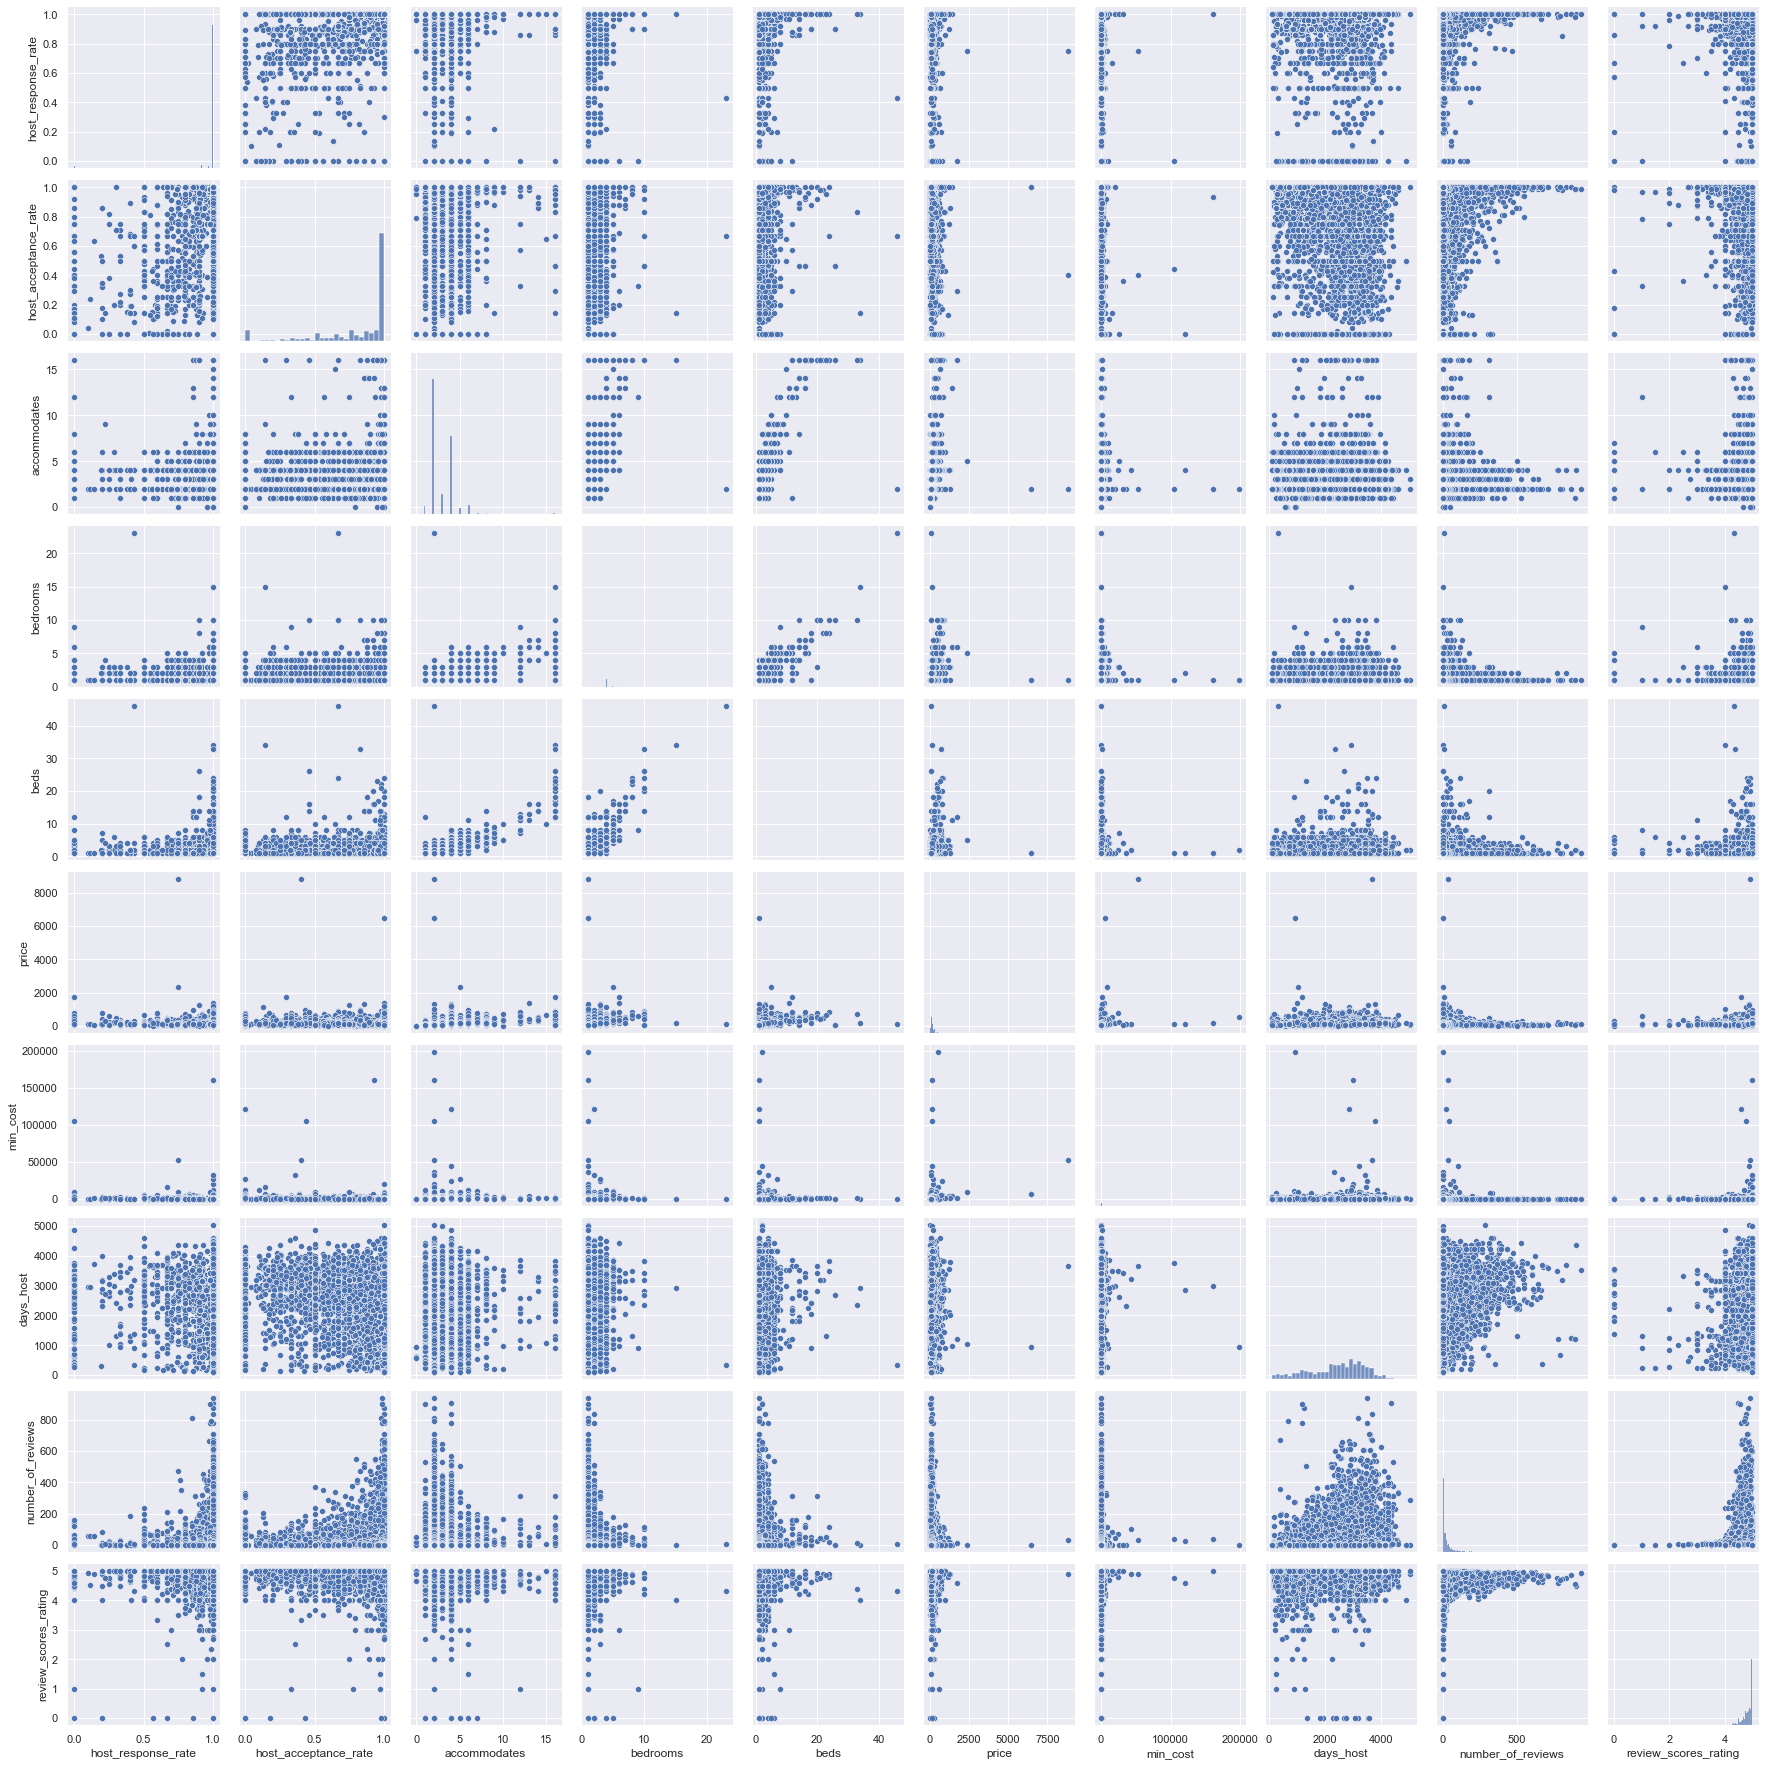

In [28]:
sn.pairplot(clean_all[['host_response_rate','host_acceptance_rate','accommodates','bedrooms',
                       'beds','price','min_cost','days_host','number_of_reviews',
                       'review_scores_rating']])

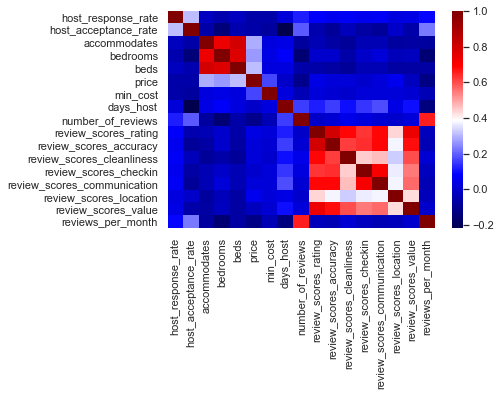

In [29]:
# Based on this heatmap and the correlation matrix and pairsplots above we decided to
# make a regression model on the ratings
corrMatrix = round(corr,2)
sn.heatmap(corrMatrix,cmap='seismic', annot=False)
plt.show()

#  3 Machine Learning Models

In [30]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split as split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MaxAbsScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, make_scorer,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor

import time

import warnings
warnings.filterwarnings('ignore')

# Making scorers for classification and regression
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

RMSE_scorer = make_scorer(RMSE,greater_is_better=False)

f1_scorer = make_scorer(f1_score,average="weighted")

# Inspiration: https://www.kaggle.com/code/naamaavi/airbnb-price-prediction-regression-project/notebook

# Mean CV Score function used to see progress during cross validation
def get_mean_cv_score(name, model, X_train, y_train, num_cv, n_verbose,scoring_param):
    print ('Model: '+name)
    print ('Begin CV fit')
    t0 = time.time()
    c_val=cross_val_score(model, X_train, y_train, cv=num_cv, verbose=n_verbose, scoring=scoring_param)
    t1 = time.time()
    print('CV ended. Elapsed time:', t1-t0)
    result = -(c_val.mean().round(4)) if scoring_param == RMSE_scorer else c_val.mean().round(4)
    return result

num_cv=10
n_verbose = 3

## 3.(1/2) Clustering Attempt

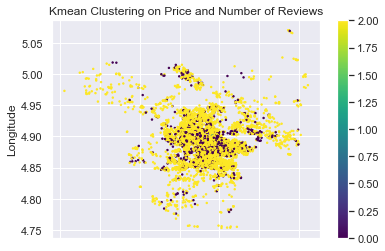

In [31]:
# Clustering on price and number of reviews for the listings in Amsterdam, we hoped to find
# a notable split in groups around the city centre
from sklearn.cluster import KMeans
X = clean_adam[['latitude','longitude','price','number_of_reviews']].dropna()
kmeans = KMeans(n_clusters = 3).fit(X[['price','number_of_reviews']])
X['label'] = kmeans.fit_predict(X[['price','number_of_reviews']])
centers = kmeans.cluster_centers_
X.plot.scatter(x='latitude',y='longitude',c=X['label'],cmap='viridis',s=2)
plt.title("Kmean Clustering on Price and Number of Reviews")
# plt.xticks()
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

## 3.1 Regression

In [32]:
scoring_param = RMSE_scorer

In [33]:
# Function that performs regression in cross validation over different regression models
# on solely the rating columns in the Data frame and prints the best performing model 

def rating_regressor(df):
    X = df.iloc[:,[1,6]]
    y = df.iloc[:,0]
    
    X_train, X_test, y_train, y_test = split(X, y, test_size=0.3)
    models_dict = {"Linear": LinearRegression(),
                   "Lasso" : Lasso(),
                   "Ridge": Ridge(),
                   "ExtraTrees": ExtraTreesRegressor()
                  }

    scores = dict()
    for name,model in models_dict.items():
        mean_cv_score=get_mean_cv_score(name,model,X_train,y_train,num_cv,n_verbose,scoring_param)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        exp_diff = np.exp(y_test) - np.exp(y_pred) #exp to get the difference between nonlog prices
        diff = y_test - y_pred
        print('Mean CV score:',mean_cv_score)
        scores.update({name:mean_cv_score})
        print('Test RMSE score:',round(RMSE(y_test,y_pred),4))
        print('Min diff:',diff.min(), exp_diff.min())
        print('Max diff:',diff.max(), exp_diff.max())
        print('Mean diff:',diff.mean(), exp_diff.mean(),'\n')
        
        plt.scatter(y_pred,diff)
        plt.title("Residuals plot:" + name)
        plt.xlabel("Predicted Values")
        plt.ylabel("Residuals")
        plt.show()
        
        res = stats.probplot(diff, plot=plt)
        plt.title("Normal QQ-plot")
        plt.show()
        
        plt.scatter(y_test, y_pred)
        plt.plot([0,5],[0,5],color='red')
        plt.title('Predicted vs. Actual Rating:'+name)
        plt.ylabel('Predicted Rating')
        plt.xlabel('Actual Rating')
        plt.show()
        
    best = min(scores, key= lambda x: scores[x])
    bestx = min(scores.values())
    print("Best performing model:",best, 'with average score of:', bestx)

Model: Linear
Begin CV fit
[CV] END ............................... score: (test=-0.148) total time=   0.0s
[CV] END ............................... score: (test=-0.124) total time=   0.0s
[CV] END ............................... score: (test=-0.182) total time=   0.0s
[CV] END ............................... score: (test=-0.142) total time=   0.0s
[CV] END ............................... score: (test=-0.172) total time=   0.0s
[CV] END ............................... score: (test=-0.140) total time=   0.0s
[CV] END ............................... score: (test=-0.146) total time=   0.0s
[CV] END ............................... score: (test=-0.128) total time=   0.0s
[CV] END ............................... score: (test=-0.162) total time=   0.0s
[CV] END ............................... score: (test=-0.176) total time=   0.0s
CV ended. Elapsed time: 0.07084178924560547
Mean CV score: 0.1521
Test RMSE score: 0.1583
Min diff: -2.665183851741677 -98.79604964517974
Max diff: 0.8907473925261

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


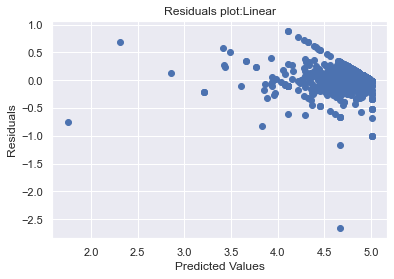

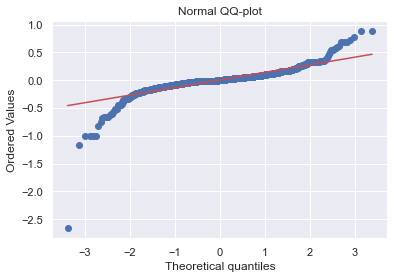

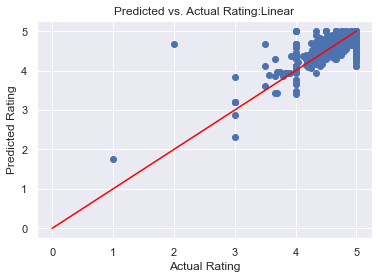

Model: Lasso
Begin CV fit
[CV] END ............................... score: (test=-0.289) total time=   0.0s
[CV] END ............................... score: (test=-0.274) total time=   0.0s
[CV] END ............................... score: (test=-0.288) total time=   0.0s
[CV] END ............................... score: (test=-0.301) total time=   0.0s
[CV] END ............................... score: (test=-0.354) total time=   0.0s
[CV] END ............................... score: (test=-0.240) total time=   0.0s
[CV] END ............................... score: (test=-0.292) total time=   0.0s
[CV] END ............................... score: (test=-0.237) total time=   0.0s
[CV] END ............................... score: (test=-0.323) total time=   0.0s
[CV] END ............................... score: (test=-0.318) total time=   0.0s
CV ended. Elapsed time: 0.04370403289794922
Mean CV score: 0.2915
Test RMSE score: 0.2753
Min diff: -3.785607728600314 -117.05584930661578
Max diff: 0.2143922713996

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


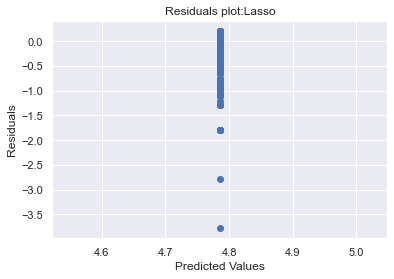

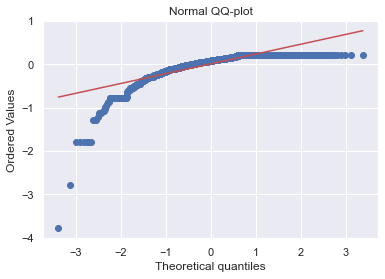

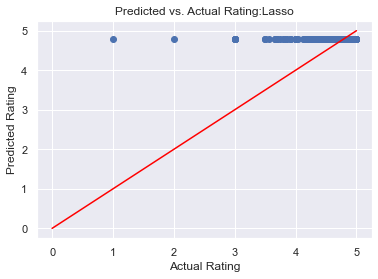

Model: Ridge
Begin CV fit
[CV] END ............................... score: (test=-0.148) total time=   0.0s
[CV] END ............................... score: (test=-0.124) total time=   0.0s
[CV] END ............................... score: (test=-0.182) total time=   0.0s
[CV] END ............................... score: (test=-0.142) total time=   0.0s
[CV] END ............................... score: (test=-0.172) total time=   0.0s
[CV] END ............................... score: (test=-0.140) total time=   0.0s
[CV] END ............................... score: (test=-0.146) total time=   0.0s
[CV] END ............................... score: (test=-0.128) total time=   0.0s
[CV] END ............................... score: (test=-0.162) total time=   0.0s
[CV] END ............................... score: (test=-0.176) total time=   0.0s
CV ended. Elapsed time: 0.0466456413269043
Mean CV score: 0.1521
Test RMSE score: 0.1583
Min diff: -2.6645852008688875 -98.73250086261375
Max diff: 0.88945280024203

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


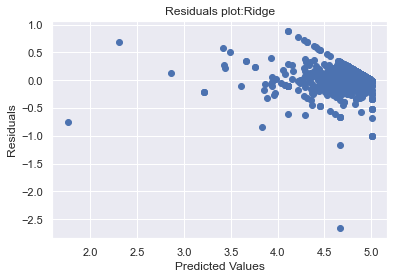

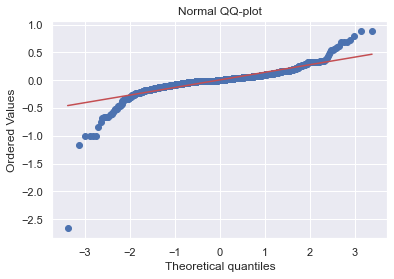

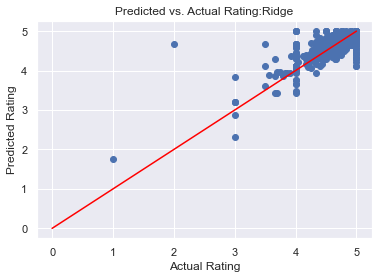

Model: ExtraTrees
Begin CV fit


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-0.181) total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END ............................... score: (test=-0.141) total time=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] END ............................... score: (test=-0.186) total time=   0.1s
[CV] END ............................... score: (test=-0.157) total time=   0.1s
[CV] END ............................... score: (test=-0.179) total time=   0.1s
[CV] END ............................... score: (test=-0.165) total time=   0.1s
[CV] END ............................... score: (test=-0.167) total time=   0.1s
[CV] END ............................... score: (test=-0.142) total time=   0.2s
[CV] END ............................... score: (test=-0.166) total time=   0.2s
[CV] END ............................... score: (test=-0.182) total time=   0.2s
CV ended. Elapsed time: 2.493469715118408


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.4s finished


Mean CV score: 0.1665
Test RMSE score: 0.1708
Min diff: -2.778307692307692 -111.51390319373817
Max diff: 0.9941999999999998 86.54534985220872
Mean diff: 0.0057577885361619185 1.397298554778498 



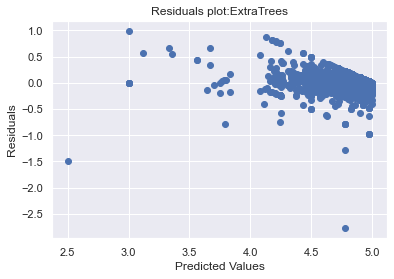

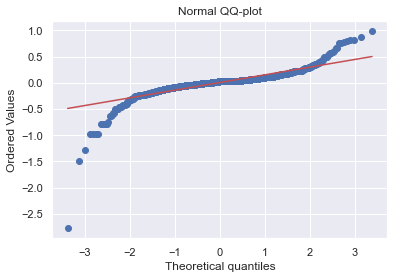

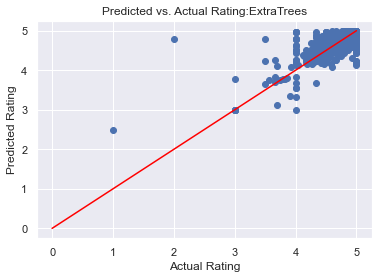

Best performing model: Linear with average score of: 0.1521


In [34]:
rating_regressor(clean_all.loc[:,'review_scores_rating':'review_scores_value'].dropna())

In [35]:
# Function to make the dataset ready for regression on any of the columns

def regression_ready(df1):
    df = df1.copy()
    
    # unique verification methods
    verifs = list()
    for i in df['host_verifications']:
        for v in i:
            if v not in verifs and v != '':
                verifs.append(v)

    # dummy column for each of the verification methods
    for j in verifs:
        isin = df['no_host_verifications'].copy()
        for i in range(len(df['host_verifications'])):
            isin.iloc[i] = j in df['host_verifications'].iloc[i]
        df["host_"+j] = isin

    df = df.drop(['id','name','description','neighborhood_overview','host_id',
                                    'host_name','host_since','host_location','host_about',
                                    'host_response_time','license','host_listings_count','property_type',
                                    'bathrooms_text','first_review','amenities',
                                    'last_review',
                                    'calculated_host_listings_count_entire_homes',
                                   'calculated_host_listings_count_private_rooms',
                                   'calculated_host_listings_count_shared_rooms',
                                   'host_neighbourhood','neighbourhood','host_verifications'],axis=1)

    # dummy columns for categorical columns
    df = pd.get_dummies(df,columns=['neighbourhood_cleansed','room_type','city'],
                                   drop_first=False)

    
    df=df.dropna()
    return df.reset_index()

In [36]:
regression_all = regression_ready(clean_all.copy())
regression_adam = regression_all[regression_all['city_Amsterdam']==1]
regression_haag = regression_all[regression_all['city_The Hague']==1]
regression_rdam = regression_all[regression_all['city_Rotterdam']==1]

In [37]:
regression_all

,index,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,...,neighbourhood_cleansed_Zuiderpark,neighbourhood_cleansed_Zuidwal,neighbourhood_cleansed_Zuidwijk,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,city_Amsterdam,city_Rotterdam,city_The Hague
0,0,1.0,1.00,True,1,True,True,52.36435,4.94358,2,...,0,0,0,0,0,1,0,1,0,0
1,1,1.0,0.98,False,2,True,True,52.36407,4.89393,2,...,0,0,0,0,0,1,0,1,0,0
2,2,1.0,1.00,True,1,True,True,52.38761,4.89188,2,...,0,0,0,0,0,1,0,1,0,0
3,3,1.0,0.99,True,2,True,True,52.36775,4.89092,2,...,0,0,0,0,0,1,0,1,0,0
4,4,1.0,0.99,True,2,True,True,52.36584,4.89111,1,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4316,7129,1.0,1.00,False,1,True,True,52.09362,4.30307,4,...,0,0,0,1,0,0,0,0,0,1
4317,7130,1.0,1.00,False,0,True,True,52.08223,4.30325,2,...,0,0,0,1,0,0,0,0,0,1
4318,7139,1.0,1.00,False,0,True,False,52.06847,4.33642,5,...,0,0,0,0,0,1,0,0,0,1
4319,7149,1.0,0.97,False,0,True,True,52.07519,4.38675,3,...,0,0,0,1,0,0,0,0,0,1


In [38]:
# GridsearchCV to find optimal alpha for Ridge
param_grid = {'ridge__alpha': np.logspace(-1,10,100)}
grid = GridSearchCV(make_pipeline(StandardScaler(),MaxAbsScaler(),Ridge()),
                    param_grid,scoring=scoring_param,cv=num_cv,verbose=1)
X_train, X_test, y_train, y_test = split(regression_all.drop(axis=1, columns=['price']), 
                                                         regression_all['price'].apply(np.log), 
                                                         test_size =0.3, random_state=123)
grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.score(X_test,y_test))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
{'ridge__alpha': 10000000000.0}
-0.5554075072380099


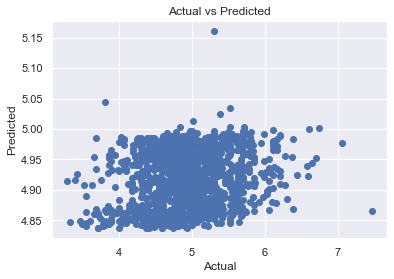

Log RMSE: 0.5476239072496009
Exp RMSE: 114.0189346052649


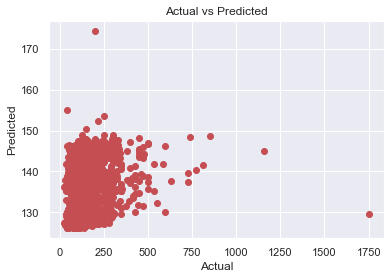

In [39]:
# Best found alpha in action
df = regression_all
X = df.drop(axis=1, columns=['price'])
y = df['price'].apply(np.log)

X_train, X_test, y_train, y_test = split(X,y,test_size =0.3, random_state=123)
model = Ridge(10000000000)
model.fit(X_train,y_train)
    
# coef = np.concatenate((model.feature_names_in_.reshape(1,-1), model.coef_.reshape(1,-1)),axis=0)
# print(coef)
y_pred = model.predict(X_test)
plt.scatter(y_test,y_pred)
plt.title("Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()
plt.scatter(np.exp(y_test),np.exp(y_pred),color='r')
plt.title("Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
print("Log RMSE:" ,RMSE(y_test,y_pred))
print("Exp RMSE:", RMSE(np.exp(y_test),np.exp(y_pred)))

In [40]:
# Preprocessing polynomial features and standard scaler setup for regression models
poly = Pipeline([('Standard_Scaler', StandardScaler()),
                 ('Polynomial_Transformer', PolynomialFeatures(degree=2, interaction_only=True))
                                  ])
std = Pipeline([('Standard_Scaler', StandardScaler())])

In [41]:
# Pipe setup from regression models
lasso_pipe = Pipeline([('Standard', std),
                        ('Lasso_regressor', Lasso())
                       ])

lin_pipe_poly = Pipeline([('Polynomial', poly),
                        ('Linear_regressor', LinearRegression())
                       ])

lin_pipe = Pipeline([('Standard', std),
                        ('Linear_regressor', LinearRegression())
                       ])

ridge_pipe_poly = Pipeline([('Polynomial', poly),
                             ('Ridge_Regressor', Ridge())
                            ])

ridge_pipe = Pipeline([('Standard', std),
                             ('Ridge_Regressor', Ridge())
                            ])

RF_pipe_poly = Pipeline([('Polynomial', poly),
                    ('RFE_regressor', RandomForestRegressor())
                  ])

RF_pipe = Pipeline([('Standard', std),
                    ('RFE_regressor', RandomForestRegressor())
                  ])

ET_pipe_poly = Pipeline([('Polynomial', poly),
                        ('ET_regressor', ExtraTreesRegressor())
                       ])

ET_pipe= Pipeline([('Standard', std),
                        ('ET_regressor', ExtraTreesRegressor())
                       ])

In [42]:
pipes_dict_all = {'Lasso':lasso_pipe,
                  'Ridge':ridge_pipe,
                  'Random Forest':RF_pipe, 
                  'Extra Trees':ET_pipe,
#                   'LG_poly':lin_pipe_poly,
#                   'RG_poly':ridge_pipe_poly,
#                   'RF_poly':RF_pipe_poly, 
#                   'ET_poly':ET_pipe_poly
                 }

Skewness: 0.167468
Kurtosis: 0.360233


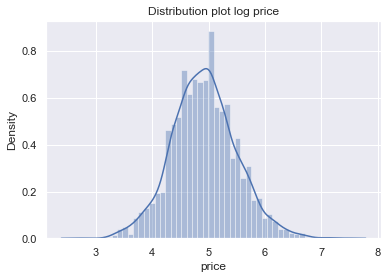

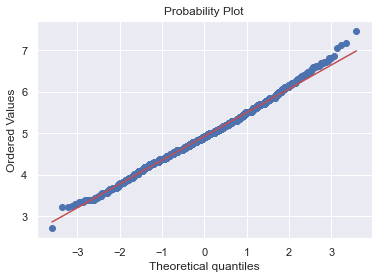

In [43]:
# Normality of log price

sn.distplot(regression_all['price'].apply(np.log), kde=True,)
plt.title("Distribution plot log price")
fig = plt.figure()
res = stats.probplot(regression_all['price'].apply(np.log), plot=plt)
print("Skewness: %f" % regression_all['price'].apply(np.log).skew())
print("Kurtosis: %f" % regression_all['price'].apply(np.log).kurt())

In [44]:
# Function that performs several different regression models in CV and prints scores, plots results 
# and best performing model

def regression_results(pipes_dict, df , num_cv, n_verbose, scoring_param):
    X_train, X_test, y_train, y_test = split(df.drop(axis=1, columns=['price']), 
                                                         df['price'].apply(np.log), 
                                                         test_size =0.3, random_state=123)
    scores=dict()
    for name,model in pipes_dict.items():
        mean_cv_score=get_mean_cv_score(name,model,X_train,y_train,num_cv,n_verbose,scoring_param)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        exp_diff = np.exp(y_test) - np.exp(y_pred)
        diff = y_test - y_pred
        print('Mean CV score:',mean_cv_score)
        scores.update({name:mean_cv_score})
        print('Test RMSE score:',round(RMSE(y_test,y_pred),4))
        print('Min diff:',diff.min(), exp_diff.min())
        print('Max diff:',diff.max(), exp_diff.max())
        print('Mean diff:',diff.mean(), exp_diff.mean(),'\n')
        
#         plt.scatter(np.exp(y_pred), diff); # print resids vs predictions
        plt.scatter(y_pred,diff)
        plt.title("Residuals plot:" + name)
        plt.xlabel("Predicted Values")
        plt.ylabel("Residuals")
        plt.show()
        
        res = stats.probplot(diff, plot=plt)
        plt.show()
        
        plt.scatter(y_test, y_pred)
        plt.plot([0,10],[0,10],color='red')
        plt.title('Predicted vs. Actual Rental Price (log):'+name)
        plt.ylabel('Rental Price (log) Predicted')
        plt.xlabel('Rental Price (log) Actual')
        plt.show()
        
    best = min(scores, key= lambda x: scores[x])
    bestx = min(scores.values())
    print("Best performing model:",best, 'with average score of:', bestx)

Model: Lasso
Begin CV fit
[CV] END ............................... score: (test=-0.578) total time=   0.0s
[CV] END ............................... score: (test=-0.590) total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] END ............................... score: (test=-0.626) total time=   0.0s
[CV] END ............................... score: (test=-0.609) total time=   0.0s
[CV] END ............................... score: (test=-0.587) total time=   0.0s
[CV] END ............................... score: (test=-0.573) total time=   0.0s
[CV] END ............................... score: (test=-0.526) total time=   0.0s
[CV] END ............................... score: (test=-0.575) total time=   0.0s
[CV] END ............................... score: (test=-0.580) total time=   0.0s
[CV] END ............................... score: (test=-0.557) total time=   0.0s
CV ended. Elapsed time: 1.0255441665649414


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished


Mean CV score: 0.5799
Test RMSE score: 0.5554
Min diff: -1.6230254347743065 -109.8468340518248
Max diff: 2.548508766138924 1613.1531659481748
Mean diff: 0.007974513602307415 25.42918753645555 



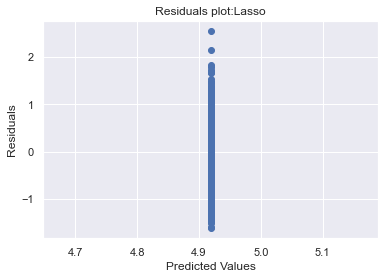

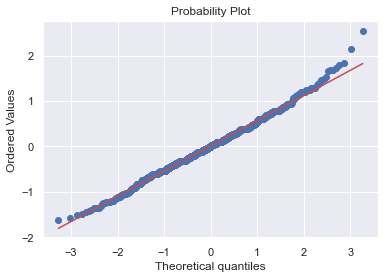

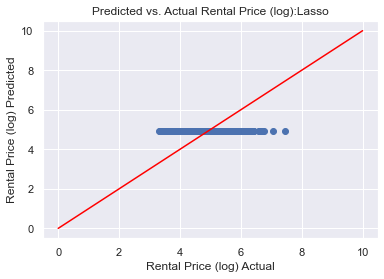

Model: Ridge
Begin CV fit
[CV] END ............................... score: (test=-0.348) total time=   0.0s
[CV] END ............................ score: (test=-1655.169) total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] END ............................... score: (test=-0.344) total time=   0.0s
[CV] END ............................... score: (test=-0.438) total time=   0.0s
[CV] END ............................... score: (test=-0.355) total time=   0.0s
[CV] END ............................... score: (test=-0.346) total time=   0.0s
[CV] END ............................... score: (test=-0.366) total time=   0.0s
[CV] END ............................... score: (test=-0.345) total time=   0.0s
[CV] END ............................... score: (test=-0.352) total time=   0.0s
[CV] END ............................... score: (test=-0.552) total time=   0.0s
CV ended. Elapsed time: 1.0043082237243652


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished


Mean CV score: 165.8615
Test RMSE score: 0.3332
Min diff: -2.219722951500489 -1230.7170513010612
Max diff: 2.3230967505767257 1010.8718431467124
Mean diff: -0.005714905624086114 5.733260915440255 



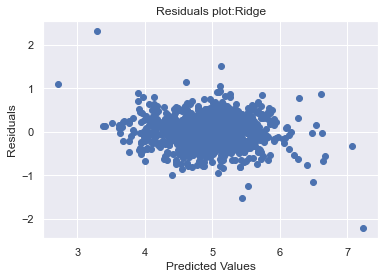

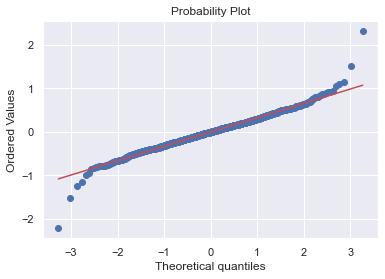

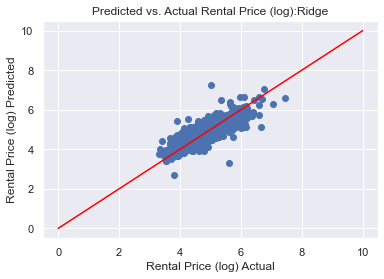

Model: Random Forest
Begin CV fit


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-0.081) total time=   3.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] END ............................... score: (test=-0.079) total time=   3.8s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.7s remaining:    0.0s


[CV] END ............................... score: (test=-0.076) total time=   3.9s
[CV] END ............................... score: (test=-0.097) total time=   3.6s
[CV] END ............................... score: (test=-0.104) total time=   3.6s
[CV] END ............................... score: (test=-0.050) total time=   3.6s
[CV] END ............................... score: (test=-0.072) total time=   3.6s
[CV] END ............................... score: (test=-0.100) total time=   3.6s
[CV] END ............................... score: (test=-0.098) total time=   3.6s
[CV] END ............................... score: (test=-0.098) total time=   3.6s
CV ended. Elapsed time: 37.81721496582031


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   37.7s finished


Mean CV score: 0.0854
Test RMSE score: 0.0926
Min diff: -0.9308188103005586 -137.94421460785094
Max diff: 1.0523663589899321 989.6767202139298
Mean diff: 0.000857126201093864 2.0380187221076826 



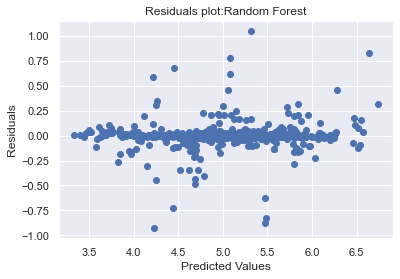

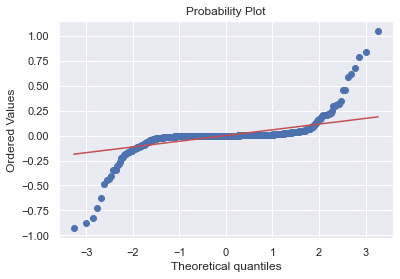

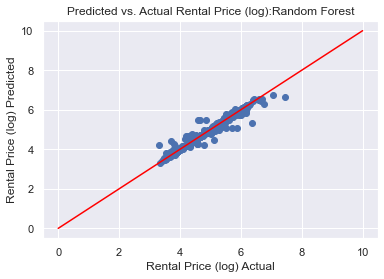

Model: Extra Trees
Begin CV fit


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-0.248) total time=   3.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV] END ............................... score: (test=-0.244) total time=   3.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.7s remaining:    0.0s


[CV] END ............................... score: (test=-0.219) total time=   3.4s
[CV] END ............................... score: (test=-0.249) total time=   3.3s
[CV] END ............................... score: (test=-0.255) total time=   3.4s
[CV] END ............................... score: (test=-0.223) total time=   3.4s
[CV] END ............................... score: (test=-0.222) total time=   3.3s
[CV] END ............................... score: (test=-0.237) total time=   3.3s
[CV] END ............................... score: (test=-0.247) total time=   3.3s
[CV] END ............................... score: (test=-0.218) total time=   3.4s
CV ended. Elapsed time: 34.51564574241638


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   34.4s finished


Mean CV score: 0.2362
Test RMSE score: 0.2151
Min diff: -0.8660876131586215 -215.80308067410678
Max diff: 2.0219266320170686 1518.2997674977003
Mean diff: 0.008194535305933693 9.518000368669927 



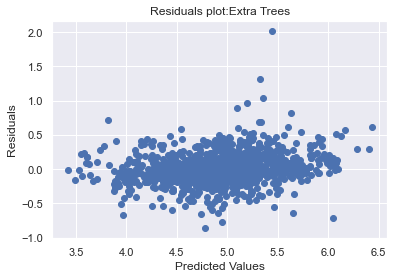

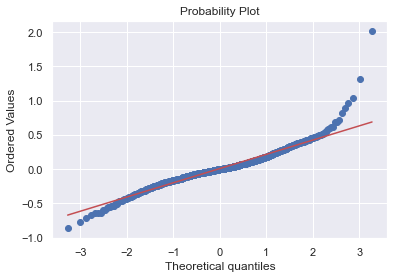

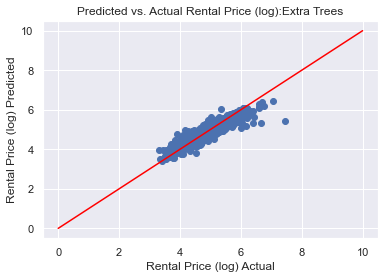

Best performing model: Random Forest with average score of: 0.0854


In [45]:
regression_results(pipes_dict_all, regression_all, num_cv, n_verbose, scoring_param)

Model: Lasso
Begin CV fit
[CV] END ............................... score: (test=-0.576) total time=   0.0s
[CV] END ............................... score: (test=-0.565) total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] END ............................... score: (test=-0.594) total time=   0.0s
[CV] END ............................... score: (test=-0.561) total time=   0.0s
[CV] END ............................... score: (test=-0.581) total time=   0.0s
[CV] END ............................... score: (test=-0.511) total time=   0.0s
[CV] END ............................... score: (test=-0.542) total time=   0.0s
[CV] END ............................... score: (test=-0.604) total time=   0.0s
[CV] END ............................... score: (test=-0.556) total time=   0.0s
[CV] END ............................... score: (test=-0.509) total time=   0.0s
CV ended. Elapsed time: 0.7622461318969727
Mean CV score: 0.5599
Test RMSE score: 0.55
Min diff: -1.7264816680116337 -120.14192024399591
Max diff: 1.7606581434512467 703.8580797560044
Mean diff: 0.022981210150664504 28.292514190438133 



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


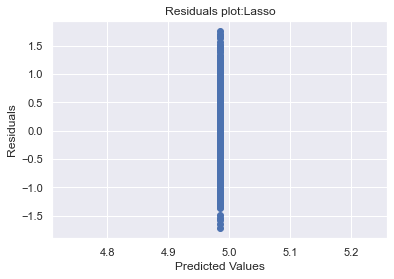

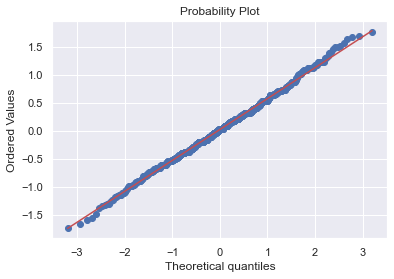

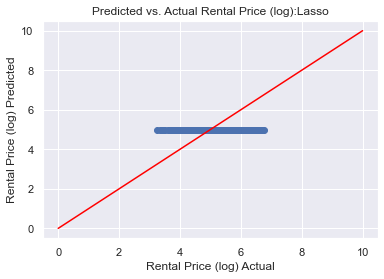

Model: Ridge
Begin CV fit
[CV] END ............................... score: (test=-0.340) total time=   0.0s
[CV] END ............................... score: (test=-0.362) total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] END ............................... score: (test=-0.615) total time=   0.0s
[CV] END ............................... score: (test=-0.311) total time=   0.0s
[CV] END ............................... score: (test=-0.354) total time=   0.0s
[CV] END ............................... score: (test=-0.285) total time=   0.0s
[CV] END ............................... score: (test=-0.418) total time=   0.0s
[CV] END ............................... score: (test=-0.343) total time=   0.0s
[CV] END ............................... score: (test=-0.305) total time=   0.0s
[CV] END ............................... score: (test=-0.360) total time=   0.0s
CV ended. Elapsed time: 0.7169272899627686
Mean CV score: 0.3692
Test RMSE score: 1440.205
Min diff: -1.4043133439613693 -430.2735581014614
Max diff: 45520.502645334804 610.3122074305379
Mean diff: 45.571860495652835 8.62598976921144 



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished


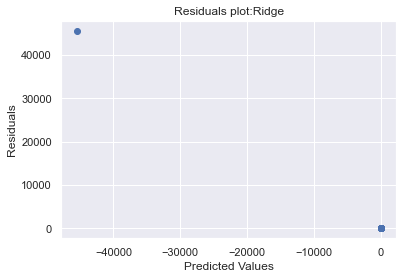

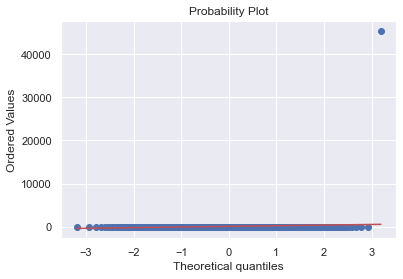

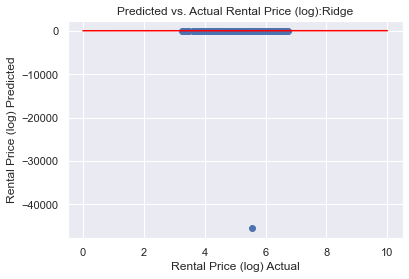

Model: Random Forest
Begin CV fit


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-0.109) total time=   2.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV] END ............................... score: (test=-0.094) total time=   2.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s


[CV] END ............................... score: (test=-0.069) total time=   2.4s
[CV] END ............................... score: (test=-0.073) total time=   2.4s
[CV] END ............................... score: (test=-0.138) total time=   2.4s
[CV] END ............................... score: (test=-0.048) total time=   2.4s
[CV] END ............................... score: (test=-0.036) total time=   2.4s
[CV] END ............................... score: (test=-0.102) total time=   2.4s
[CV] END ............................... score: (test=-0.105) total time=   2.4s
[CV] END ............................... score: (test=-0.091) total time=   2.5s
CV ended. Elapsed time: 25.437527894973755


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   25.3s finished


Mean CV score: 0.0863
Test RMSE score: 0.0747
Min diff: -0.6668432988482751 -127.99054403364639
Max diff: 0.6354276514952044 280.1064829329158
Mean diff: -0.0020276843514865713 0.8870878563049259 



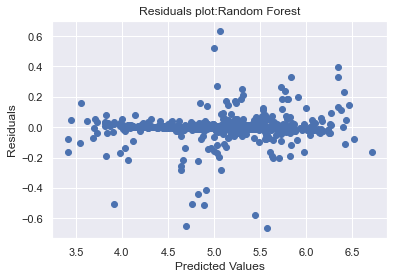

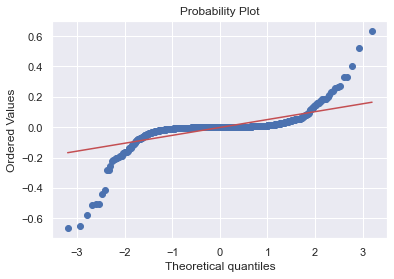

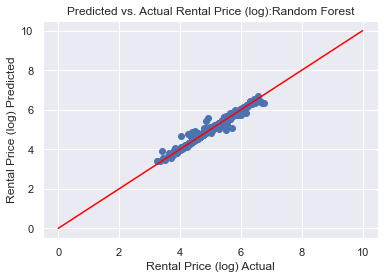

Model: Extra Trees
Begin CV fit


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-0.221) total time=   2.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV] END ............................... score: (test=-0.250) total time=   2.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s


[CV] END ............................... score: (test=-0.215) total time=   2.2s
[CV] END ............................... score: (test=-0.198) total time=   2.2s
[CV] END ............................... score: (test=-0.242) total time=   2.2s
[CV] END ............................... score: (test=-0.178) total time=   2.2s
[CV] END ............................... score: (test=-0.231) total time=   2.2s
[CV] END ............................... score: (test=-0.236) total time=   2.1s
[CV] END ............................... score: (test=-0.222) total time=   2.2s
[CV] END ............................... score: (test=-0.190) total time=   2.2s
CV ended. Elapsed time: 22.858862161636353


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.8s finished


Mean CV score: 0.2184
Test RMSE score: 0.2162
Min diff: -1.1495633204649733 -159.6042428487714
Max diff: 1.2915337448375563 559.0914891937123
Mean diff: -0.001929335336845687 7.792485743360675 



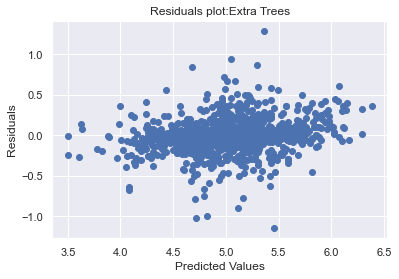

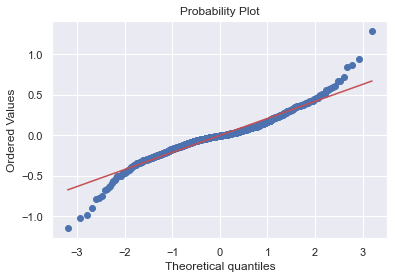

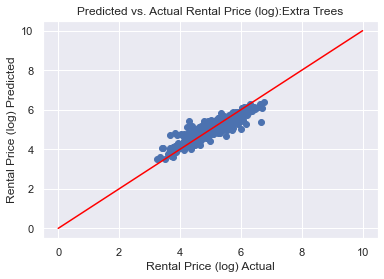

Best performing model: Random Forest with average score of: 0.0863


In [46]:
regression_results(pipes_dict_all, regression_adam, num_cv, n_verbose, scoring_param)

Model: Lasso
Begin CV fit
[CV] END ............................... score: (test=-0.602) total time=   0.0s
[CV] END ............................... score: (test=-0.649) total time=   0.0s
[CV] END ............................... score: (test=-0.473) total time=   0.0s
[CV] END ............................... score: (test=-0.622) total time=   0.0s
[CV] END ............................... score: (test=-0.572) total time=   0.0s
[CV] END ............................... score: (test=-0.550) total time=   0.0s
[CV] END ............................... score: (test=-0.546) total time=   0.0s
[CV] END ............................... score: (test=-0.556) total time=   0.0s
[CV] END ............................... score: (test=-0.449) total time=   0.0s
[CV] END ............................... score: (test=-0.550) total time=   0.0s
CV ended. Elapsed time: 0.19367241859436035


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Mean CV score: 0.5569
Test RMSE score: 0.5465
Min diff: -1.5434627978393771 -92.01927007217952
Max diff: 1.2165471421935443 277.98072992782056
Mean diff: -0.11080543503953613 2.5148914185037015 



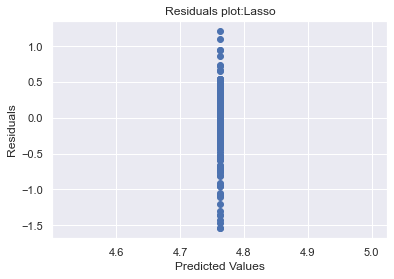

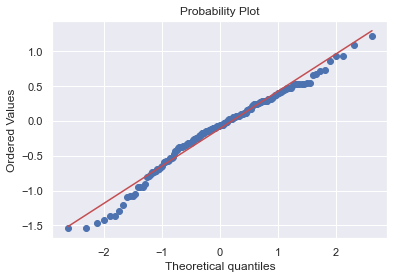

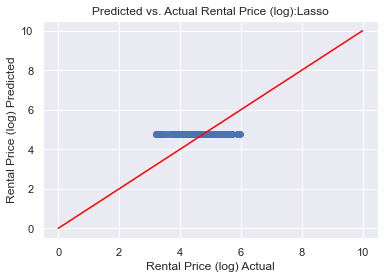

Model: Ridge
Begin CV fit
[CV] END ............................... score: (test=-0.360) total time=   0.0s
[CV] END ............................... score: (test=-1.988) total time=   0.0s
[CV] END ............................... score: (test=-0.335) total time=   0.0s
[CV] END ............................... score: (test=-0.517) total time=   0.0s
[CV] END ............................... score: (test=-0.319) total time=   0.0s
[CV] END ............................... score: (test=-0.327) total time=   0.0s
[CV] END ............................... score: (test=-0.405) total time=   0.0s
[CV] END ............................... score: (test=-0.255) total time=   0.0s
[CV] END ............................... score: (test=-0.332) total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] END ............................... score: (test=-0.412) total time=   0.0s
CV ended. Elapsed time: 0.19904470443725586
Mean CV score: 0.525
Test RMSE score: 0.3567
Min diff: -1.030785345025985 -140.8904719615308
Max diff: 0.894768590280945 145.09983308859316
Mean diff: -0.07845497872146202 -6.210691181131769 



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


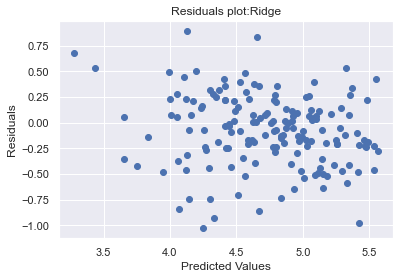

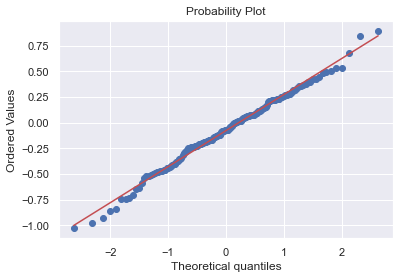

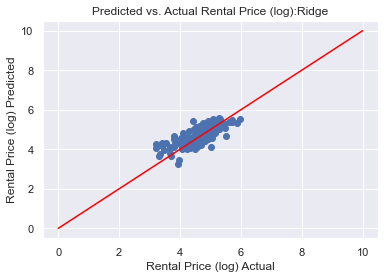

Model: Random Forest
Begin CV fit


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-0.238) total time=   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] END ............................... score: (test=-0.373) total time=   0.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] END ............................... score: (test=-0.194) total time=   0.4s
[CV] END ............................... score: (test=-0.288) total time=   0.4s
[CV] END ............................... score: (test=-0.233) total time=   0.4s
[CV] END ............................... score: (test=-0.219) total time=   0.4s
[CV] END ............................... score: (test=-0.184) total time=   0.4s
[CV] END ............................... score: (test=-0.145) total time=   0.4s
[CV] END ............................... score: (test=-0.223) total time=   0.4s
[CV] END ............................... score: (test=-0.258) total time=   0.4s
CV ended. Elapsed time: 4.737794876098633


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.6s finished


Mean CV score: 0.2356
Test RMSE score: 0.2204
Min diff: -0.8109994342976674 -93.61510708762685
Max diff: 0.5207167767690164 147.6357505848808
Mean diff: -0.038124537525429346 1.244834745097157 



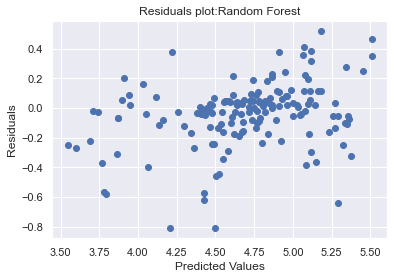

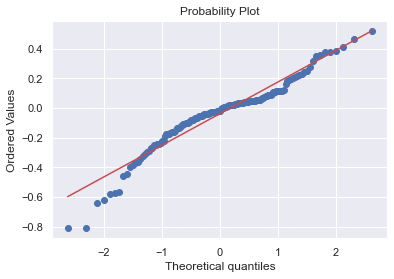

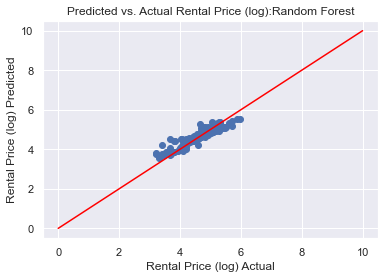

Model: Extra Trees
Begin CV fit


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-0.307) total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ............................... score: (test=-0.432) total time=   0.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] END ............................... score: (test=-0.339) total time=   0.3s
[CV] END ............................... score: (test=-0.345) total time=   0.3s
[CV] END ............................... score: (test=-0.278) total time=   0.3s
[CV] END ............................... score: (test=-0.243) total time=   0.3s
[CV] END ............................... score: (test=-0.276) total time=   0.3s
[CV] END ............................... score: (test=-0.213) total time=   0.3s
[CV] END ............................... score: (test=-0.295) total time=   0.3s
[CV] END ............................... score: (test=-0.285) total time=   0.3s
CV ended. Elapsed time: 4.175891160964966


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.1s finished


Mean CV score: 0.3013
Test RMSE score: 0.3124
Min diff: -1.1923352936210114 -66.37251290199295
Max diff: 0.6156574770562795 162.09438132176632
Mean diff: -0.04784657964828607 0.781213626017216 



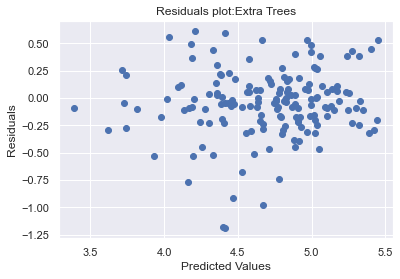

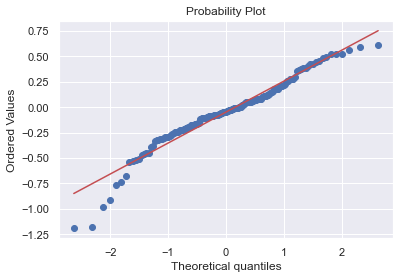

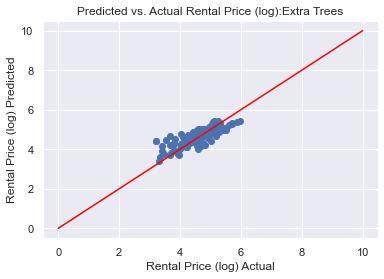

Best performing model: Random Forest with average score of: 0.2356


In [47]:
regression_results(pipes_dict_all, regression_haag, num_cv, n_verbose, scoring_param)

Model: Lasso
Begin CV fit
[CV] END ............................... score: (test=-0.632) total time=   0.0s
[CV] END ............................... score: (test=-0.520) total time=   0.0s
[CV] END ............................... score: (test=-0.625) total time=   0.0s
[CV] END ............................... score: (test=-0.524) total time=   0.0s
[CV] END ............................... score: (test=-0.538) total time=   0.0s
[CV] END ............................... score: (test=-0.406) total time=   0.0s
[CV] END ............................... score: (test=-0.602) total time=   0.0s
[CV] END ............................... score: (test=-0.675) total time=   0.0s
[CV] END ............................... score: (test=-0.732) total time=   0.0s
[CV] END ............................... score: (test=-0.579) total time=   0.0s
CV ended. Elapsed time: 0.1722412109375
Mean CV score: 0.5831
Test RMSE score: 0.5102
Min diff: -1.0711437566387487 -67.1550562298446
Max diff: 1.4827557646362033 3

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


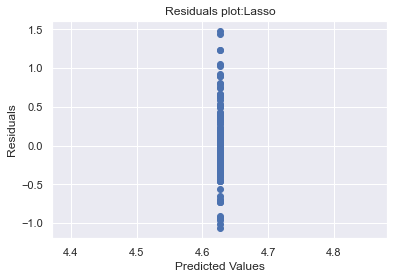

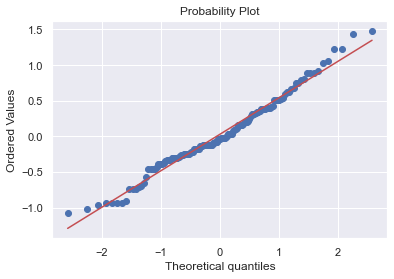

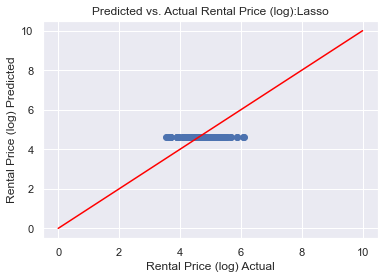

Model: Ridge
Begin CV fit
[CV] END ............................... score: (test=-0.413) total time=   0.0s
[CV] END ............................... score: (test=-0.536) total time=   0.0s
[CV] END ............................... score: (test=-0.407) total time=   0.0s
[CV] END ............................... score: (test=-0.304) total time=   0.0s
[CV] END ............................... score: (test=-0.501) total time=   0.0s
[CV] END ............................... score: (test=-0.316) total time=   0.0s
[CV] END ............................... score: (test=-0.418) total time=   0.0s
[CV] END ............................... score: (test=-0.486) total time=   0.0s
[CV] END ............................... score: (test=-0.402) total time=   0.0s
[CV] END ............................... score: (test=-0.336) total time=   0.0s
CV ended. Elapsed time: 0.19020819664001465


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Mean CV score: 0.4121
Test RMSE score: 0.3688
Min diff: -0.9203671909811328 -113.26589609400457
Max diff: 1.8026083143770801 205.79226810977832
Mean diff: 0.04800474803090907 10.84096854656089 



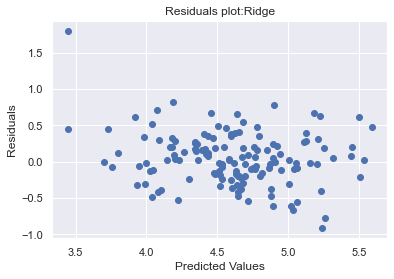

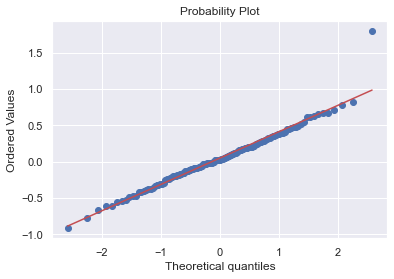

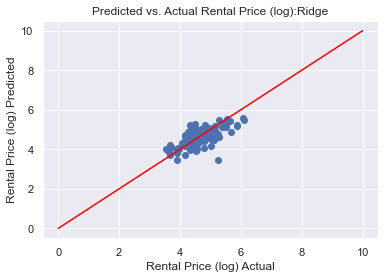

Model: Random Forest
Begin CV fit


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-0.242) total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ............................... score: (test=-0.401) total time=   0.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] END ............................... score: (test=-0.323) total time=   0.3s
[CV] END ............................... score: (test=-0.232) total time=   0.3s
[CV] END ............................... score: (test=-0.313) total time=   0.3s
[CV] END ............................... score: (test=-0.236) total time=   0.3s
[CV] END ............................... score: (test=-0.270) total time=   0.3s
[CV] END ............................... score: (test=-0.298) total time=   0.3s
[CV] END ............................... score: (test=-0.250) total time=   0.3s
[CV] END ............................... score: (test=-0.189) total time=   0.3s
CV ended. Elapsed time: 4.155011177062988


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.1s finished


Mean CV score: 0.2755
Test RMSE score: 0.2497
Min diff: -1.1548098105104811 -126.058348924083
Max diff: 0.8062724713884295 173.6178189772408
Mean diff: -0.013543030833152416 3.5673476057342306 



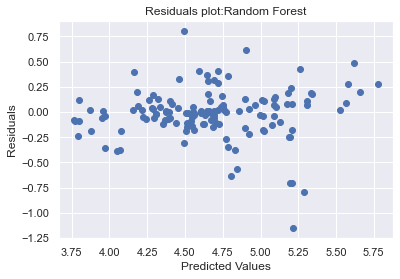

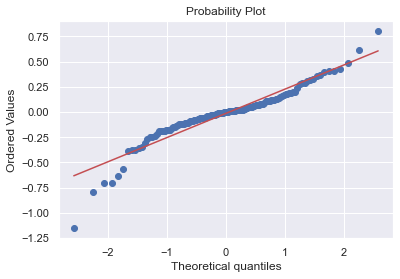

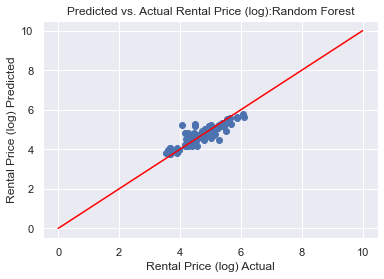

Model: Extra Trees
Begin CV fit


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-0.397) total time=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] END ............................... score: (test=-0.523) total time=   0.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV] END ............................... score: (test=-0.369) total time=   0.3s
[CV] END ............................... score: (test=-0.267) total time=   0.3s
[CV] END ............................... score: (test=-0.324) total time=   0.3s
[CV] END ............................... score: (test=-0.317) total time=   0.3s
[CV] END ............................... score: (test=-0.352) total time=   0.3s
[CV] END ............................... score: (test=-0.412) total time=   0.3s
[CV] END ............................... score: (test=-0.321) total time=   0.3s
[CV] END ............................... score: (test=-0.226) total time=   0.3s
CV ended. Elapsed time: 3.758859395980835


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.7s finished


Mean CV score: 0.3508
Test RMSE score: 0.291
Min diff: -1.0546803350282028 -108.52131938445844
Max diff: 0.6974213468661885 159.971048810257
Mean diff: -0.013374985754282346 5.006870301797067 



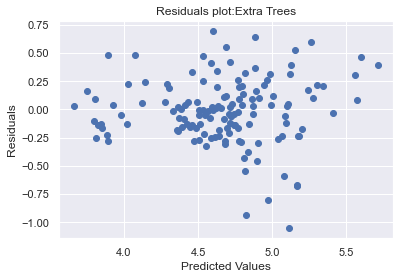

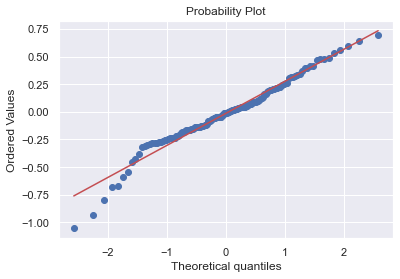

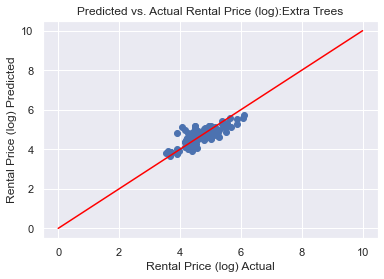

Best performing model: Random Forest with average score of: 0.2755


In [48]:
regression_results(pipes_dict_all, regression_rdam, num_cv, n_verbose, scoring_param)

## 3.2 Classification

In [49]:
scoring_param = f1_scorer

In [50]:
# Function to obtain text columns with result columns for validation
def text(city):
    text_class = city[['description','neighborhood_overview',
                       'host_is_superhost','host_identity_verified']]
    
    text_class = text_class.fillna("")
    
    text_class["full_text"] = text_class["description"] + text_class["neighborhood_overview"]
    
    return text_class

# Function that fits and test single classification on text processed reviews DF
def verified_classification(txt):
    X = txt["full_text"].values
    #y = txt["host_identity_verified"].values
    y = txt["host_is_superhost"].values
    
    X_train, X_test, y_train, y_test = split(X, y, test_size=0.2)
    
    model = make_pipeline(TfidfVectorizer(), MultinomialNB())
    model = model.fit(X_train,y_train)
    
    predicted = model.predict(X_test)
    f1 = f1_score(y_test, predicted)
    
    return f1

# Kfold classification on text processed reviews DF
def verified_kfold(text):
    X = text["full_text"].values
    y = text["host_identity_verified"].values
    #y = text["host_is_superhost"].values
           
    X_train, X_test, y_train, y_test = split(X, y, test_size=0.2)
    kf = KFold(n_splits = 10)
    
    f1score = []
    
    confusion = np.zeros((2,2))
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = make_pipeline(TfidfVectorizer(), MultinomialNB())
        model.fit(X_train, y_train)
        ypred = model.predict(X_test)
        
        f1 = f1_score(y_test, ypred)
        f1score.append(f1)

        
    return statistics.mean(f1score)  

In [51]:
verified_kfold(text(clean_all))

0.9008186083452439

In [52]:
verified_kfold(text(clean_adam))

0.8984878270561966

In [53]:
verified_kfold(text(clean_haag))

0.917314893382533

In [54]:
verified_kfold(text(clean_rdam))

0.898610929203575

In [55]:
# Function to make the dataset ready for classification on room type
def classif_ready(df1):
    df = df1.copy()
    
    # retrieving unique verification method
    verifs = list()
    for i in df['host_verifications']:
        for v in i:
            if v not in verifs and v != '':
                verifs.append(v)

    # making dummy columns for each unique verification method
    for j in verifs:
        isin = df['no_host_verifications'].copy()
        for i in range(len(df['host_verifications'])):
            isin.iloc[i] = j in df['host_verifications'].iloc[i]
        df["host_"+j] = isin

    # dropping irrelevant columns
    df = df.drop(['id','name','description','neighborhood_overview','host_id',
                                    'host_name','host_since','host_location','host_about',
                                    'host_response_time','license','host_listings_count','property_type',
                                    'bathrooms_text','first_review','amenities',
                                    'last_review',
                                    'calculated_host_listings_count_entire_homes',
                                   'calculated_host_listings_count_private_rooms',
                                   'calculated_host_listings_count_shared_rooms',
                                   'host_neighbourhood','neighbourhood','host_verifications'],axis=1)

    # dummying categorical columns
    df = pd.get_dummies(df,columns=['neighbourhood_cleansed','city'],
                                   drop_first=False)

    
    df=df.dropna()
    return df.reset_index()

In [56]:
classif_all = classif_ready(clean_all)
classif_all

,index,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,room_type,...,neighbourhood_cleansed_Zeeheldenkwartier,neighbourhood_cleansed_Zestienhoven,neighbourhood_cleansed_Zevenkamp,neighbourhood_cleansed_Zuid,neighbourhood_cleansed_Zuiderpark,neighbourhood_cleansed_Zuidwal,neighbourhood_cleansed_Zuidwijk,city_Amsterdam,city_Rotterdam,city_The Hague
0,0,1.0,1.00,True,1,True,True,52.36435,4.94358,Private room,...,0,0,0,0,0,0,0,1,0,0
1,1,1.0,0.98,False,2,True,True,52.36407,4.89393,Private room,...,0,0,0,0,0,0,0,1,0,0
2,2,1.0,1.00,True,1,True,True,52.38761,4.89188,Private room,...,0,0,0,0,0,0,0,1,0,0
3,3,1.0,0.99,True,2,True,True,52.36775,4.89092,Private room,...,0,0,0,0,0,0,0,1,0,0
4,4,1.0,0.99,True,2,True,True,52.36584,4.89111,Private room,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4316,7129,1.0,1.00,False,1,True,True,52.09362,4.30307,Entire home/apt,...,0,0,0,0,0,0,0,0,0,1
4317,7130,1.0,1.00,False,0,True,True,52.08223,4.30325,Entire home/apt,...,0,0,0,0,0,0,0,0,0,1
4318,7139,1.0,1.00,False,0,True,False,52.06847,4.33642,Private room,...,0,0,0,0,0,0,0,0,0,1
4319,7149,1.0,0.97,False,0,True,True,52.07519,4.38675,Entire home/apt,...,0,0,0,0,0,0,0,0,0,1


In [57]:
# Function that performs classification in cross validation over different classification models
# parameter "ready" indicates if the function classif_ready() was used on the provided dataframe

def room_classif(df,isReadied=False):
    if not isReadied:
#         df = df[['room_type','price','bedrooms','beds','accommodates','number_of_reviews',
#                       'review_scores_value','review_scores_rating','review_scores_accuracy'
#                       ,'host_is_superhost','host_response_rate','host_acceptance_rate']].dropna()
        df = df[['room_type','price','bedrooms','host_acceptance_rate']].dropna()
        corrMatrix = round(df.corr(),2)
        sn.heatmap(corrMatrix,cmap='seismic', annot = True)
        plt.show()
    
    y = df['room_type']
    X = df.drop('room_type',axis=1)
    X_train, X_test, y_train, y_test = split(X, y, test_size=0.3)
    
    kf = KFold(n_splits=10)
    models_dict = {"Logistic Regression": LogisticRegression(),
                   "DecisionTree": DecisionTreeClassifier(),
                   "Random Forest":RandomForestClassifier(),
                   "Multinomial NB":MultinomialNB()
                  }
    
    scores = dict()
    for name,model in models_dict.items():
        mean_cv_score=get_mean_cv_score(name,model,X_train,y_train,num_cv,n_verbose,scoring_param)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        print()
        print('Mean CV score:',mean_cv_score)
        scores.update({name:mean_cv_score})
        print('Test RMSE score:',round(f1_score(y_test,y_pred,average='weighted'),4))
        print()
        
    best = max(scores, key= lambda x: scores[x])
    bestx = max(scores.values())
    print("Best performing model:",best, 'with average score of:', bestx)

In [58]:
room_classif(classif_all,True)

Model: Logistic Regression
Begin CV fit
[CV] END ................................ score: (test=0.229) total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END ................................ score: (test=0.809) total time=   0.1s
[CV] END ................................ score: (test=0.219) total time=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] END ................................ score: (test=0.224) total time=   0.0s
[CV] END ................................ score: (test=0.777) total time=   0.2s
[CV] END ................................ score: (test=0.783) total time=   0.2s
[CV] END ................................ score: (test=0.781) total time=   0.3s
[CV] END ................................ score: (test=0.786) total time=   0.2s
[CV] END ................................ score: (test=0.753) total time=   0.3s
[CV] END ................................ score: (test=0.767) total time=   0.2s
CV ended. Elapsed time: 2.524383068084717

Mean CV score: 0.6126
Test RMSE score: 0.2264

Model: DecisionTree
Begin CV fit


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.789) total time=   0.0s
[CV] END ................................ score: (test=0.834) total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] END ................................ score: (test=0.806) total time=   0.0s
[CV] END ................................ score: (test=0.810) total time=   0.0s
[CV] END ................................ score: (test=0.823) total time=   0.0s
[CV] END ................................ score: (test=0.765) total time=   0.0s
[CV] END ................................ score: (test=0.799) total time=   0.0s
[CV] END ................................ score: (test=0.803) total time=   0.0s
[CV] END ................................ score: (test=0.804) total time=   0.0s
[CV] END ................................ score: (test=0.785) total time=   0.0s
CV ended. Elapsed time: 1.0807483196258545


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Mean CV score: 0.8019
Test RMSE score: 0.82

Model: Random Forest
Begin CV fit
[CV] END ................................ score: (test=0.862) total time=   0.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] END ................................ score: (test=0.897) total time=   0.5s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV] END ................................ score: (test=0.887) total time=   0.5s
[CV] END ................................ score: (test=0.898) total time=   0.5s
[CV] END ................................ score: (test=0.843) total time=   0.4s
[CV] END ................................ score: (test=0.879) total time=   0.5s
[CV] END ................................ score: (test=0.856) total time=   0.4s
[CV] END ................................ score: (test=0.839) total time=   0.4s
[CV] END ................................ score: (test=0.888) total time=   0.4s
[CV] END ................................ score: (test=0.881) total time=   0.4s
CV ended. Elapsed time: 5.549185752868652


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.4s finished



Mean CV score: 0.8728
Test RMSE score: 0.8614

Model: Multinomial NB
Begin CV fit
[CV] END ................................ score: (test=0.471) total time=   0.0s
[CV] END ................................ score: (test=0.654) total time=   0.0s
[CV] END ................................ score: (test=0.467) total time=   0.0s
[CV] END ................................ score: (test=0.487) total time=   0.0s
[CV] END ................................ score: (test=0.456) total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.438) total time=   0.0s
[CV] END ................................ score: (test=0.422) total time=   0.0s
[CV] END ................................ score: (test=0.477) total time=   0.0s
[CV] END ................................ score: (test=0.453) total time=   0.0s
[CV] END ................................ score: (test=0.464) total time=   0.0s
CV ended. Elapsed time: 0.4275500774383545

Mean CV score: 0.4791
Test RMSE score: 0.4816

Best performing model: Random Forest with average score of: 0.8728


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


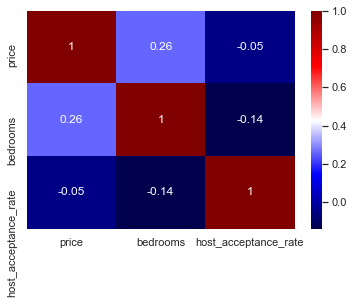

Model: Logistic Regression
Begin CV fit
[CV] END ................................ score: (test=0.744) total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.742) total time=   0.0s
[CV] END ................................ score: (test=0.729) total time=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] END ................................ score: (test=0.719) total time=   0.0s
[CV] END ................................ score: (test=0.737) total time=   0.0s
[CV] END ................................ score: (test=0.741) total time=   0.1s
[CV] END ................................ score: (test=0.692) total time=   0.1s
[CV] END ................................ score: (test=0.714) total time=   0.1s
[CV] END ................................ score: (test=0.714) total time=   0.1s
[CV] END ................................ score: (test=0.703) total time=   0.0s
CV ended. Elapsed time: 1.5588314533233643

Mean CV score: 0.7237
Test RMSE score: 0.729

Model: DecisionTree
Begin CV fit
[CV] END ................................ score: (test=0.729) total time=   0.0s
[CV] END ................................ score: (test=0.668) total time=   0.0s
[CV] END ................................ score: (test=0.733) total time=   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.714) total time=   0.0s
[CV] END ................................ score: (test=0.735) total time=   0.0s
[CV] END ................................ score: (test=0.752) total time=   0.0s
[CV] END ................................ score: (test=0.712) total time=   0.0s
[CV] END ................................ score: (test=0.698) total time=   0.0s
[CV] END ................................ score: (test=0.742) total time=   0.0s
[CV] END ................................ score: (test=0.711) total time=   0.0s
CV ended. Elapsed time: 0.1149897575378418

Mean CV score: 0.7194
Test RMSE score: 0.7279

Model: Random Forest
Begin CV fit


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.754) total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END ................................ score: (test=0.710) total time=   0.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] END ................................ score: (test=0.730) total time=   0.2s
[CV] END ................................ score: (test=0.722) total time=   0.2s
[CV] END ................................ score: (test=0.736) total time=   0.2s
[CV] END ................................ score: (test=0.754) total time=   0.2s
[CV] END ................................ score: (test=0.716) total time=   0.2s
[CV] END ................................ score: (test=0.689) total time=   0.2s
[CV] END ................................ score: (test=0.753) total time=   0.2s
[CV] END ................................ score: (test=0.697) total time=   0.2s
CV ended. Elapsed time: 2.9228527545928955


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished



Mean CV score: 0.726
Test RMSE score: 0.7453

Model: Multinomial NB
Begin CV fit
[CV] END ................................ score: (test=0.516) total time=   0.0s
[CV] END ................................ score: (test=0.514) total time=   0.0s
[CV] END ................................ score: (test=0.514) total time=   0.0s
[CV] END ................................ score: (test=0.511) total time=   0.0s
[CV] END ................................ score: (test=0.511) total time=   0.0s
[CV] END ................................ score: (test=0.513) total time=   0.0s
[CV] END ................................ score: (test=0.514) total time=   0.0s
[CV] END ................................ score: (test=0.514) total time=   0.0s
[CV] END ................................ score: (test=0.513) total time=   0.0s
[CV] END ................................ score: (test=0.513) total time=   0.0s
CV ended. Elapsed time: 0.11652731895446777

Mean CV score: 0.5136
Test RMSE score: 0.5089

Best performing 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [59]:
room_classif(clean_all)

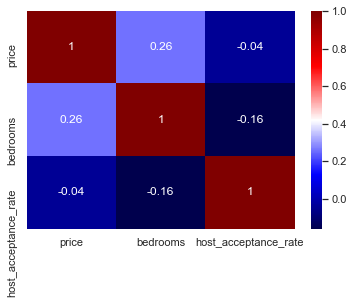

Model: Logistic Regression
Begin CV fit
[CV] END ................................ score: (test=0.727) total time=   0.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.762) total time=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] END ................................ score: (test=0.718) total time=   0.0s
[CV] END ................................ score: (test=0.746) total time=   0.0s
[CV] END ................................ score: (test=0.738) total time=   0.0s
[CV] END ................................ score: (test=0.757) total time=   0.0s
[CV] END ................................ score: (test=0.742) total time=   0.1s
[CV] END ................................ score: (test=0.792) total time=   0.0s
[CV] END ................................ score: (test=0.752) total time=   0.0s
[CV] END ................................ score: (test=0.792) total time=   0.0s
CV ended. Elapsed time: 1.4088339805603027


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



Mean CV score: 0.7528
Test RMSE score: 0.7284

Model: DecisionTree
Begin CV fit
[CV] END ................................ score: (test=0.721) total time=   0.0s
[CV] END ................................ score: (test=0.743) total time=   0.0s
[CV] END ................................ score: (test=0.744) total time=   0.0s
[CV] END ................................ score: (test=0.764) total time=   0.0s
[CV] END ................................ score: (test=0.745) total time=   0.0s
[CV] END ................................ score: (test=0.720) total time=   0.0s
[CV] END ................................ score: (test=0.698) total time=   0.0s
[CV] END ................................ score: (test=0.759) total time=   0.0s
[CV] END ................................ score: (test=0.726) total time=   0.0s
[CV] END ................................ score: (test=0.744) total time=   0.0s
CV ended. Elapsed time: 0.09344768524169922

Mean CV score: 0.7366
Test RMSE score: 0.7269

Model: Random For

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.751) total time=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END ................................ score: (test=0.750) total time=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] END ................................ score: (test=0.774) total time=   0.1s
[CV] END ................................ score: (test=0.763) total time=   0.1s
[CV] END ................................ score: (test=0.768) total time=   0.2s
[CV] END ................................ score: (test=0.745) total time=   0.1s
[CV] END ................................ score: (test=0.735) total time=   0.1s
[CV] END ................................ score: (test=0.776) total time=   0.2s
[CV] END ................................ score: (test=0.750) total time=   0.1s
[CV] END ................................ score: (test=0.755) total time=   0.1s
CV ended. Elapsed time: 2.4237539768218994


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.3s finished



Mean CV score: 0.7566
Test RMSE score: 0.7478

Model: Multinomial NB
Begin CV fit
[CV] END ................................ score: (test=0.514) total time=   0.0s
[CV] END ................................ score: (test=0.516) total time=   0.0s
[CV] END ................................ score: (test=0.516) total time=   0.0s
[CV] END ................................ score: (test=0.516) total time=   0.0s
[CV] END ................................ score: (test=0.512) total time=   0.0s
[CV] END ................................ score: (test=0.512) total time=   0.0s
[CV] END ................................ score: (test=0.512) total time=   0.0s
[CV] END ................................ score: (test=0.512) total time=   0.0s
[CV] END ................................ score: (test=0.515) total time=   0.0s
[CV] END ................................ score: (test=0.515) total time=   0.0s
CV ended. Elapsed time: 0.08608770370483398

Mean CV score: 0.5139
Test RMSE score: 0.4902

Best performing

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [60]:
room_classif(clean_adam)

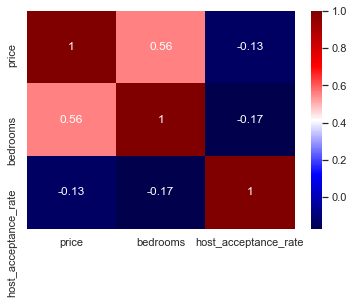

Model: Logistic Regression
Begin CV fit
[CV] END ................................ score: (test=0.861) total time=   0.0s
[CV] END ................................ score: (test=0.671) total time=   0.0s
[CV] END ................................ score: (test=0.798) total time=   0.0s
[CV] END ................................ score: (test=0.775) total time=   0.0s
[CV] END ................................ score: (test=0.626) total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.659) total time=   0.0s
[CV] END ................................ score: (test=0.732) total time=   0.0s
[CV] END ................................ score: (test=0.700) total time=   0.0s
[CV] END ................................ score: (test=0.793) total time=   0.0s
[CV] END ................................ score: (test=0.792) total time=   0.0s
CV ended. Elapsed time: 0.4366593360900879

Mean CV score:

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


 0.7407
Test RMSE score: 0.7284

Model: DecisionTree
Begin CV fit
[CV] END ................................ score: (test=0.871) total time=   0.0s
[CV] END ................................ score: (test=0.709) total time=   0.0s
[CV] END ................................ score: (test=0.715) total time=   0.0s
[CV] END ................................ score: (test=0.775) total time=   0.0s
[CV] END ................................ score: (test=0.758) total time=   0.0s
[CV] END ................................ score: (test=0.817) total time=   0.0s
[CV] END ................................ score: (test=0.795) total time=   0.0s
[CV] END ................................ score: (test=0.843) total time=   0.0s
[CV] END ................................ score: (test=0.825) total time=   0.0s
[CV] END ................................ score: (test=0.730) total time=   0.0s
CV ended. Elapsed time: 0.04400944709777832

Mean CV score: 0.7837
Test RMSE score: 0.7809

Model: Random Forest
Begin CV fi

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] END ................................ score: (test=0.666) total time=   0.0s
[CV] END ................................ score: (test=0.715) total time=   0.0s
[CV] END ................................ score: (test=0.747) total time=   0.0s
[CV] END ................................ score: (test=0.777) total time=   0.0s
[CV] END ................................ score: (test=0.755) total time=   0.0s
[CV] END ................................ score: (test=0.786) total time=   0.0s
[CV] END ................................ score: (test=0.818) total time=   0.0s
[CV] END ................................ score: (test=0.888) total time=   0.0s
[CV] END ................................ score: (test=0.836) total time=   0.0s
CV ended. Elapsed time: 1.2047810554504395

Mean CV score: 0.7813
Test RMSE score: 0.7733

Model: Multinomial NB
Begin CV fit
[CV] END ................................ score: (test=0.571) total time=   0.0s
[CV] END ................................ score: (test=0.543) to

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [61]:
room_classif(clean_haag)

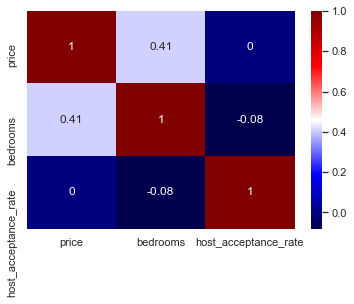

Model: Logistic Regression
Begin CV fit
[CV] END ................................ score: (test=0.560) total time=   0.0s
[CV] END ................................ score: (test=0.556) total time=   0.0s
[CV] END ................................ score: (test=0.628) total time=   0.0s
[CV] END ................................ score: (test=0.645) total time=   0.0s
[CV] END ................................ score: (test=0.555) total time=   0.0s
[CV] END ................................ score: (test=0.555) total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.680) total time=   0.0s
[CV] END ................................ score: (test=0.555) total time=   0.0s
[CV] END ................................ score: (test=0.643) total time=   0.0s
[CV] END ................................ score: (test=0.473) total time=   0.0s
CV ended. Elapsed time: 0.34520888328552246

Mean CV score: 0.585
Test RMSE score: 0.5736

Model: DecisionTree
Begin CV fit
[CV] END ................................ score: (test=0.810) total time=   0.0s
[CV] END ................................ score: (test=0.686) total time=   0.0s
[CV] END ................................ score: (test=0.779) total time=   0.0s
[CV] END ................................ score: (test=0.744) total time=   0.0s
[CV] END ................................ score: (test=0.798) total time=   0.0s
[CV] END ................................ score: (test=0.729) total time=   0.0s
[CV] END ................................ score: (test=0.717) tota

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Mean CV score: 0.7472
Test RMSE score: 0.7033

Model: Random Forest
Begin CV fit
[CV] END ................................ score: (test=0.787) total time=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] END ................................ score: (test=0.712) total time=   0.0s
[CV] END ................................ score: (test=0.759) total time=   0.0s
[CV] END ................................ score: (test=0.824) total time=   0.0s
[CV] END ................................ score: (test=0.868) total time=   0.0s
[CV] END ................................ score: (test=0.678) total time=   0.0s
[CV] END ................................ score: (test=0.776) total time=   0.0s
[CV] END ................................ score: (test=0.865) total time=   0.0s
[CV] END ................................ score: (test=0.793) total time=   0.0s
[CV] END ................................ score: (test=0.638) total time=   0.0s
CV ended. Elapsed time: 1.2358970642089844

Mean CV score: 0.77
Test RMSE score: 0.7778

Model: Multinomial NB
Begin CV fit
[CV] END ................................ score: (test=0.503) total time=   0.0s
[CV] END ................................ score: (test=0.518) tota

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [62]:
room_classif(clean_rdam)